<a href="https://colab.research.google.com/github/Matan-Birnboim/LanguageComputationCognition/blob/main/Language%20Computation%20Cognition%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
GDRIVE_DIR = '/content/gdrive/MyDrive/096222-pset-3/Structured Task (sentence decoding)'

Mounted at /content/gdrive


In [ ]:
!pip install -q transformers
!pip install -U -q sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import sys
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest,  f_regression
from transformers import AutoTokenizer, BertModel
import matplotlib.pyplot as plt
import math
import itertools
from tqdm import tqdm
import pickle
from sentence_transformers import SentenceTransformer
import warnings
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from gensim.models import KeyedVectors
import seaborn as sns

In [ ]:
# Download and extract the data and learn_decoder.py
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56" -O files.zip && rm -rf /tmp/cookies.txt
!unzip files.zip
!rm files.zip

--2023-07-05 12:11:28--  https://docs.google.com/uc?export=download&confirm=t&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56
Resolving docs.google.com (docs.google.com)... 142.250.4.139, 142.250.4.100, 142.250.4.113, ...
Connecting to docs.google.com (docs.google.com)|142.250.4.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/08fqg513vcklh3ia9jdabmunmp7hd3kr/1688559075000/01333689271208460322/*/1xZaorRH-xxjfochvSesAhOTUg82_Xq56?e=download&uuid=eb270b82-14f6-47ee-be39-8a3a8ace78e7 [following]
--2023-07-05 12:11:28--  https://doc-0g-54-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/08fqg513vcklh3ia9jdabmunmp7hd3kr/1688559075000/01333689271208460322/*/1xZaorRH-xxjfochvSesAhOTUg82_Xq56?e=download&uuid=eb270b82-14f6-47ee-be39-8a3a8ace78e7
Resolving doc-0g-54-docs.googleusercontent.com (doc-0g-54-docs.googleusercontent.com)... 74.125.200.132, 2404

In [ ]:
#Let's load the functions from learn_decoder.py
from learn_decoder import *

In [ ]:
!time wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip
!unzip glove.42B.300d.zip

--2023-07-05 12:11:44--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip
Resolving huggingface.co (huggingface.co)... 13.224.249.119, 13.224.249.43, 13.224.249.44, ...
Connecting to huggingface.co (huggingface.co)|13.224.249.119|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/stanfordnlp/glove/357baac33090f645e71e253b3295ee1b767c98a0336e9a1d99c77e9e33b43c4a?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27glove.42B.300d.zip%3B+filename%3D%22glove.42B.300d.zip%22%3B&response-content-type=application%2Fzip&Expires=1688818305&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3N0YW5mb3JkbmxwL2dsb3ZlLzM1N2JhYWMzMzA5MGY2NDVlNzFlMjUzYjMyOTVlZTFiNzY3Yzk4YTAzMzZlOWExZDk5Yzc3ZTllMzNiNDNjNGE%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qJnJlc3BvbnNlLWNvbnRlbnQtdHlwZT0qIiwiQ29uZGl0aW9uIjp7IkRhdGVMZXNzVGhhbiI6eyJBV1M6RXBvY2hUaW1lIjoxNjg4ODE4MzA1fX19XX0_&Signature=eD5

## Utility Functions

In [ ]:
def get_glove_embeddings(word_list):
  embeddings = []
  for word in word_list:
    embeddings.append(all_embeddings[word])
  return np.array(embeddings)

In [ ]:
def cosine_similarity(x: np.ndarray, y: np.ndarray) -> float:
    common_dtype = np.float64  # Choose the desired common data type
    x = x.astype(common_dtype)
    y = y.astype(common_dtype)
    dot_product = np.dot (x,y)
    x_norm = np.linalg.norm(x)
    y_norm = np.linalg.norm(y)

    return dot_product/ (x_norm* y_norm)

In [ ]:
#calculate the rank of the true vector based on cosine similarity
def rank_based_accuracy (decoded_vec, true_vec, vectors):
  rank= {}
  true_vec_index = -1

  for i in range(vectors.shape[0]):
    rank[i]= cosine_similarity(vectors[i], decoded_vec)
    if np.array_equal(true_vec, vectors[i]):
      true_vec_index=i

  rankings = dict(sorted(rank.items(), key=lambda item: item[1], reverse= True))
  final_rank = list(rankings).index(true_vec_index)
  return final_rank + 1

In [ ]:
def calculate_rank(decoder_res, test_set, test_vectors, index, vectors, all_ranks, avg_ranking, concepts=0, semi=False):
  increments = 12 if semi else 10
  key= (index/increments)+1
  test_fold_ranking= []
  for i in np.arange(test_set.shape[0]):
    dot_prod = np.dot(test_set[i],decoder_res) #semantic vector - the model's best guess to the concept
    current_rank= rank_based_accuracy(dot_prod, test_vectors[i], vectors) #rank of the current test data
    test_fold_ranking.append(current_rank)
    if semi:
      all_ranks[index]= current_rank
    else:
      all_ranks[concepts[index]]= current_rank

    index= index+1

  avg_ranking[key]= round(sum(test_fold_ranking)/len(test_fold_ranking), 2)
  return all_ranks, avg_ranking

In [ ]:
def calculate_rank_sentences(decoder_res, test_set, vectors, concepts):
    avg_ranking = {}
    all_ranks = {}
    test_fold_ranking= []
    for i in np.arange(test_set.shape[0]):
      dot_prod = np.dot(test_set[i],decoder_res) #semantic vector - the model's best guess to the concept
      current_rank= rank_based_accuracy(dot_prod, vectors[i], vectors) #rank of the current test data
      test_fold_ranking.append(current_rank)
      all_ranks[i] = current_rank

    #avg_ranking[i]= sum(test_fold_ranking)/len(test_fold_ranking)
    return all_ranks

In [ ]:
def train_decoder(data, vectors, concepts=0, semi = False):
  all_ranks = {} #rank of each concept
  avg_ranking = {} #avg rank of each fold
  increments = 12 if semi else 10
  for i in np.arange(0, data.shape[0], increments):
    temp_test_set = data[i:i+increments]
    temp_test_vectors = vectors[i:i+increments]
    temp_train_set = np.concatenate((data[0:i], data[i+increments: data.shape[0]]))
    temp_train_vectors = np.concatenate((vectors[0:i], vectors[i+increments: data.shape[0]]))

    decoder_res = learn_decoder(temp_train_set, temp_train_vectors) #decoder matrix

    calculate_rank(decoder_res, temp_test_set, temp_test_vectors, i, vectors, all_ranks, avg_ranking, concepts, semi) #calculate rank for each concept and for each fold

    print(f'Average Score of Fold {(i/increments)+1} is: {avg_ranking[(i/increments)+1]}')

  return all_ranks, avg_ranking

In [ ]:
def pca_cumulative_var(name , data, threshold, cv=False):
  pca = PCA(n_components=data.shape[0])
  pca.fit(data)

  # Calculate cumulative explained variance
  cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
  explained_var = threshold
  index= np.abs(cumulative_variance - explained_var).argmin()
  print(f'The number of components that explain {threshold*100} % of the {name}variance is {index}')
  # Plot cumulative explained variance
  if not cv:
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.axhline(y = explained_var, color ="red", linestyle ="--")
    plt.axvline(x=index, color='red', linestyle='--')
    plt.suptitle(name + "Explained Variance per Number of Components")
    plt.show()
  return index

In [ ]:
def plot_concepts(concepts, type, description, exp):
  top_15 = dict(itertools.islice(concepts.items(), 15))
  x_axis =top_15.keys()
  y_axis = top_15.values()
  plt.figure(figsize=(10,6))
  plt.bar(x_axis, y_axis)
  x_tick = plt.xticks(rotation = 60)
  plt.title("Top 15 " +type+ description+ exp)
  plt.xlabel("Concept")
  plt.ylabel("Accuracy Score")
  plt.plot()

In [ ]:
def plot_fold_avg_acc(num_folds,avg_ranking):
  x_axis =np.arange(1,num_folds+1)
  y_axis = avg_ranking.values()
  plt.bar(x_axis, y_axis)
  x_tick = plt.xticks(range(min(x_axis), max(x_axis)+1))
  plt.title("Accuracy Score per Fold")
  plt.xlabel("Number of Fold")
  plt.ylabel("Avg Accuracy Score")

In [ ]:
def successful_failed_concepts(concepts,all_ranks):
  successful_concepts = {}
  failed_concepts = {}

  for concept in concepts:
    if all_ranks[concept]<90:
      successful_concepts[concept]= all_ranks[concept]
    else:
      failed_concepts[concept]= all_ranks[concept]

  successful_concepts = dict(sorted(successful_concepts.items(), key=lambda item: item[1]))
  failed_concepts = dict(sorted(failed_concepts.items(), key=lambda item: item[1] ,  reverse= True))

  print(f'Successful Concepts Are : {successful_concepts}')
  print(f'Number of Succesful Concepts: {len(successful_concepts)}')
  print(f'Average Rank of Succesful Concepts: {sum(successful_concepts.values()) / len(successful_concepts)}')
  print()
  print(f'Failed Concepts Are : {failed_concepts}')
  print(f'Number of Failed Concepts: {len(failed_concepts)}')
  print(f'Average Rank of Failed Concepts: {sum(failed_concepts.values()) / len(failed_concepts)}')

  return successful_concepts, failed_concepts

In [ ]:
def open_pkl(path):
  with open(path , 'rb') as f:
    data = pickle.load(f)

  return data

In [ ]:
def read_txt(path):
  data_list = []
  with open(path, 'r') as file:
      for line in file:
          line_data = line.strip().rstrip('.')  # remove dots at the end of the line
          line_data = line_data.strip().lower()  # convert the line to lowercase
          line_data = line_data.split()  # split the line by whitespace
          data_list.append(line_data)

  # convert the list into a NumPy array
  data_array = np.array(data_list)
  return data_array

In [ ]:
def find_key_passage(data, index):
  sentence_passage_id = data['labelsPassageForEachSentence'][index][0]
  sentence_key_passage = data['keyPassages'][sentence_passage_id-1][0][0]
  indices = np.where(data['keyPassages'] == sentence_key_passage)[0]
  passage_category_index_sentence = data['labelsPassageCategory'][indices][0][0]
  key_passage_category_sentence = data['keyPassageCategory'][0][passage_category_index_sentence-1][0]

  return key_passage_category_sentence

In [ ]:
def get_key_passage_dict (data):
  passage_dict={}

  for i in data:
    word= i[0]
    passage_dict[word]=0

  return passage_dict

In [ ]:
def successful_failed_topics(data, ranks):

  key_passage_dict= get_key_passage_dict(data['keyPassageCategory'][0])
  key_count = get_key_passage_dict(data['keyPassageCategory'][0])

  successful_topics={}
  failed_topics={}

  length = len(ranks)
  for i in range(length-1):
    key = find_key_passage(data,i)
    rank= ranks[i]
    key_passage_dict[key] +=rank
    key_count[key] +=1

  for key in key_passage_dict:
    key_passage_dict[key]= round(key_passage_dict[key]/key_count[key],3)

    if key_passage_dict[key] < length/2:
      successful_topics[key]= key_passage_dict[key]

    else:
      failed_topics[key]= key_passage_dict[key]

  successful_topics = dict(sorted(successful_topics.items(), key=lambda item: item[1]))
  failed_topics = dict(sorted(failed_topics.items(), key=lambda item: item[1] ,  reverse= True))

  print(f'Successful Key Passages are : {successful_topics}')
  print(f'Number of Succesful Key Passages: {len(successful_topics)}')
  print(f'Average Rank of Succesful Topics: {sum(successful_topics.values()) / len(successful_topics)}')
  print()
  print(f'Failed Key Passages are : {failed_topics}')
  print(f'Number of Failed Key Passages: {len(failed_topics)}')
  if len(failed_topics) != 0:
    print(f'Average Rank of Failed Topics: {sum(failed_topics.values()) / len(failed_topics)}')

  return successful_topics, failed_topics


## Load Data

In [ ]:
data = read_matrix("imaging_data.csv", sep=",")
vectors = read_matrix("vectors_180concepts.GV42B300.txt", sep=" ")
concepts = np.genfromtxt('stimuli_180concepts.txt', dtype=np.dtype('U')) #The names of the 180 concepts

In [ ]:
#exp2
data_exp2_path= 'gdrive/MyDrive/Structured_Task/EXP2.pkl'
concepts_exp2_path = 'gdrive/MyDrive/Structured_Task/stimuli_384sentences.txt'
vectors_exp2_path = 'gdrive/MyDrive/Structured_Task/vectors_384sentences.GV42B300.average.txt'

data_exp2= (open_pkl(data_exp2_path))
concepts_exp2= (read_txt(concepts_exp2_path))
vectors_exp2 = (read_txt(vectors_exp2_path))

#exp3
data_exp3_path= 'gdrive/MyDrive/Structured_Task/EXP3.pkl'
concepts_exp3_path='gdrive/MyDrive/Structured_Task/stimuli_243sentences.txt'
vectors_exp3_path = 'gdrive/MyDrive/Structured_Task/vectors_243sentences.GV42B300.average.txt'

data_exp3= (open_pkl(data_exp3_path))
concepts_exp3= (read_txt(concepts_exp3_path))
vectors_exp3= (read_txt(vectors_exp3_path))

fmri_exp2 = data_exp2['Fmridata']
fmri_exp3 = data_exp3['Fmridata']

<ipython-input-18-63c0fe74afd8>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_array = np.array(data_list)


In [ ]:
data_file_path = 'gdrive/MyDrive/Structured_Task/neuralData_for_EXP1.csv'
data_c = np.genfromtxt(data_file_path, delimiter=',')
data_c = data_c[1:, 1:] #remove the first row and column

In [ ]:
sentences_exp2 = []
for sentence in data_exp2['keySentences']:
  sentences_exp2.append(sentence[0][0].lower().rstrip('.'))

In [ ]:
model = SentenceTransformer('paraphrase-MiniLM-l6-v2')
sentences_exp2_bert = model.encode(sentences_exp2)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

inputs = tokenizer(list(concepts), return_tensors="pt", padding=True)
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
vectors_bert = last_hidden_states[:,1,:].detach().numpy()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
all_embeddings = {}
with open("/content/glove.42B.300d.txt", 'rt') as infile:
    for line in infile:
        word, *rest = line.split()
        all_embeddings[word] = np.array(list(map(float, rest)))

# Part 1 - Structured Tasks

## Section A

> Repeating Homework 3 Question 3 with BERT embeddings instead of GloVe.



Comparing Different cumulative variance thresholds and BERT's performance to obtain the best PCA threshold. Note that we are taking the maximum number of compnents between the BERT vectors and fMRI vectors to ensure the cumulative variance level is always met.

In [ ]:
thresholds = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
all_ranks_thresholds= {}
avg_ranks_thresholds={}
successful_concepts_bert={}
failed_concepts_bert={}
for threshold in thresholds:
  print(f'--------------------------- Threshold: {threshold} -----------------------------------------')
  n_components_bert = pca_cumulative_var("Bert Vectors ", vectors_bert, threshold, cv=True)
  n_components_data = pca_cumulative_var("fMRI Data ", data, threshold, cv=True)
  pca = PCA(n_components=max(n_components_bert, n_components_data), svd_solver = 'full')
  pca.fit(vectors_bert)
  vectors_pca = pca.transform(vectors_bert)
  pca.fit(data)
  data_pca = pca.transform(data)
  all_ranks_thresholds[threshold], avg_ranks_thresholds[threshold] = train_decoder(data_pca, vectors_pca, concepts)
  successful_concepts_bert[threshold], failed_concepts_bert[threshold]= successful_failed_concepts(concepts,all_ranks_thresholds[threshold])

--------------------------- Threshold: 0.7 -----------------------------------------
The number of components that explain 70.0 % of the Bert Vectors variance is 40
The number of components that explain 70.0 % of the fMRI Data variance is 22
Average Score of Fold 1.0 is: 60.7
Average Score of Fold 2.0 is: 61.3
Average Score of Fold 3.0 is: 51.9
Average Score of Fold 4.0 is: 71.4
Average Score of Fold 5.0 is: 79.4
Average Score of Fold 6.0 is: 47.7
Average Score of Fold 7.0 is: 80.9
Average Score of Fold 8.0 is: 62.3
Average Score of Fold 9.0 is: 49.0
Average Score of Fold 10.0 is: 55.9
Average Score of Fold 11.0 is: 55.0
Average Score of Fold 12.0 is: 70.5
Average Score of Fold 13.0 is: 49.5
Average Score of Fold 14.0 is: 34.3
Average Score of Fold 15.0 is: 46.9
Average Score of Fold 16.0 is: 78.6
Average Score of Fold 17.0 is: 57.6
Average Score of Fold 18.0 is: 57.2
Successful Concepts Are : {'do': 1, 'fish': 1, 'investigation': 1, 'kindness': 1, 'lady': 1, 'stupid': 1, 'pain': 2, 'p

We find that taking the components that explain 85-90% of the variance give the best results. We'll use 85% because it had a better accuracy score for the successful concepts.

The number of components that explain 85.0 % of the Bert Vectors variance is 71


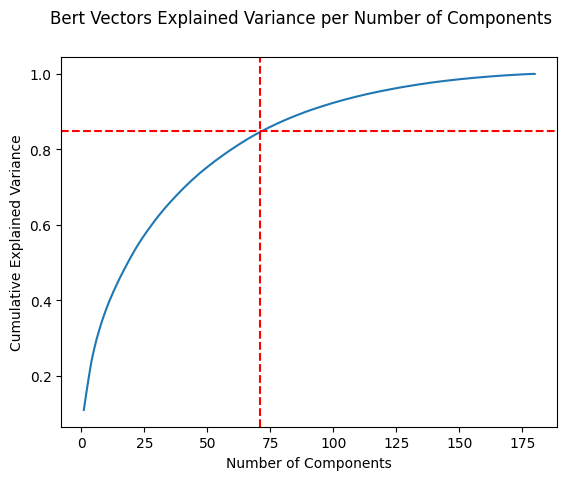

In [ ]:
n_components_bert = pca_cumulative_var("Bert Vectors ", vectors_bert, 0.85)

The number of components that explain 85.0 % of the Data variance is 61


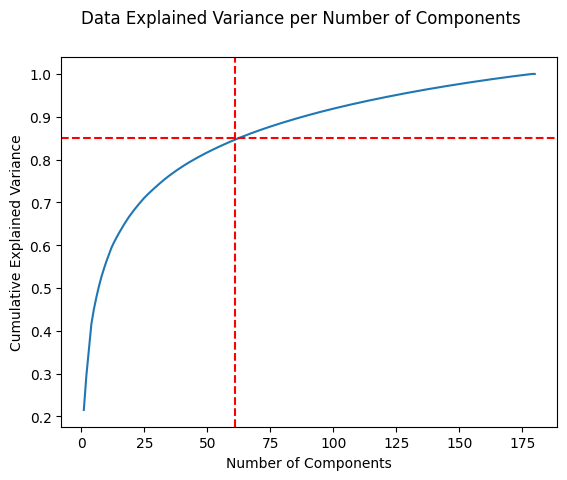

In [ ]:
n_components_data = pca_cumulative_var("Data ", data, 0.85)

Now let's plot the averaged accuracy score for each fold

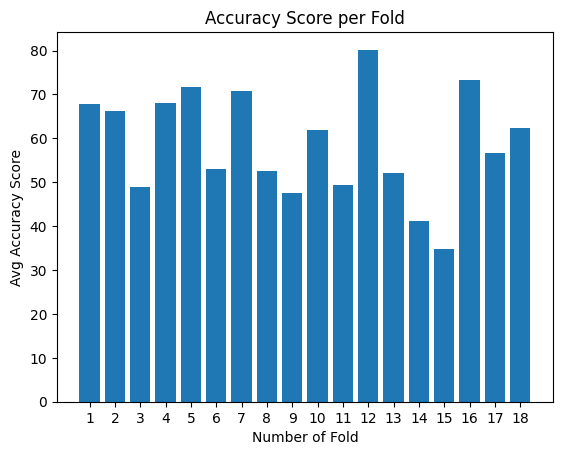

In [ ]:
plot_fold_avg_acc(18,avg_ranks_thresholds[0.85])

We'll consider a "successful concept"  as a concept with an average rank lower than 90, as a score of 90 represents random noise.

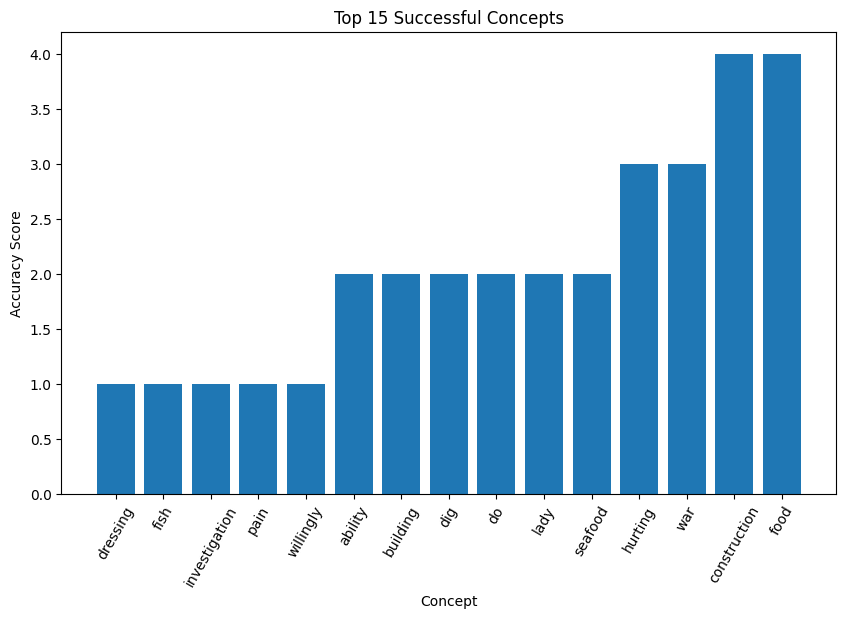

In [ ]:
plot_concepts(successful_concepts_bert[0.85], "Successful ", "Concepts", "")

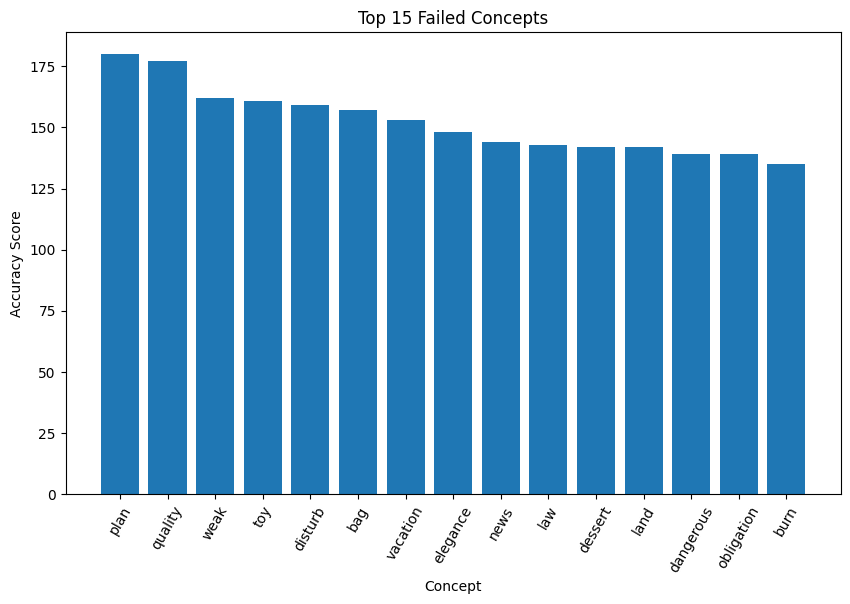

In [ ]:
plot_concepts(failed_concepts_bert[0.85], "Failed ","Concepts", "")

**Let's get a reminder of the outcome from HW3 with the GloVe embeddings. **
Note that GloVe succeeded in 134 concepts and failed in 46.


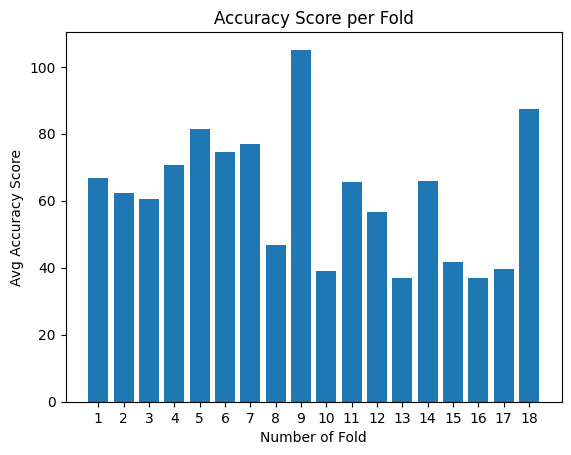

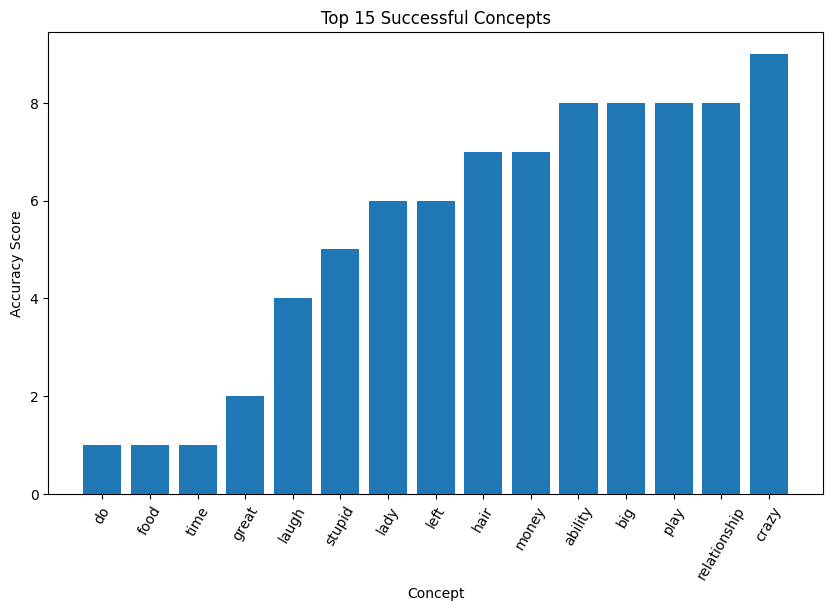
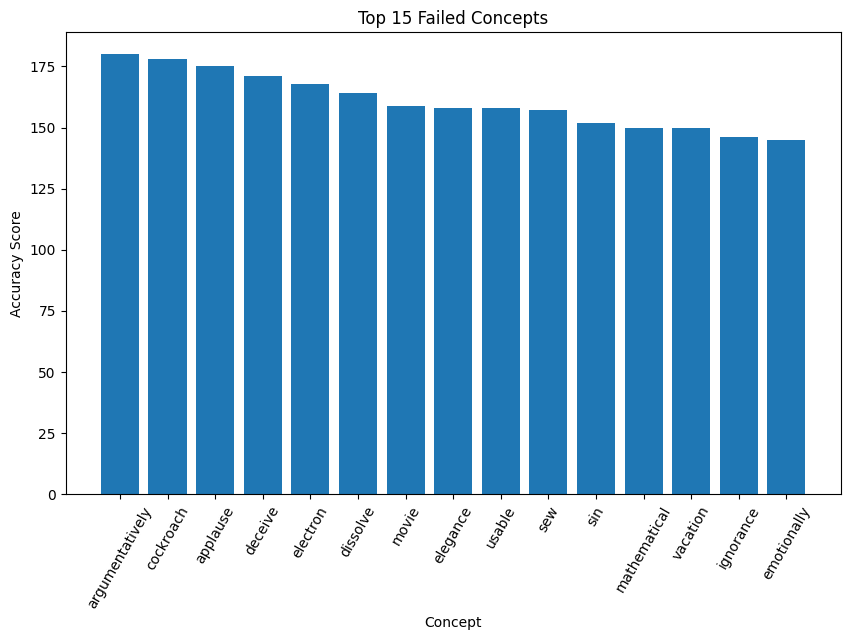

*Discussion*

We decided to comapre the BERT embeddings to GloVe, as BERT is considered a sophisticated model with more meaningful vector representations. As it is based upon a Transformer model, it maintains context more effectively. We took a pretrained BERT model and extracted the outputs of the 180 concepts that we used in HW3. As the BERT embeddings are much larger than those of GloVe, we ran into a matrix multiplication issue, as the fMRI data that was used had been adapted to fit those vectors.

To solve this issue, we performed a PCA on both the brain data, as well as the BERT embeddings. Intially we aimed for a cumulative explained variance of 80%, but then thought to perform a cross-validation and compare different explained variance thresholds. We ended up choosing 85%, as it had the ebst results (see above). This meant reducing both BERT and fMRI vectors to 71 principal compnents.

*Results*

The number of successful concepts for BERT embeddings was 133, while GloVe has 134 successful concepts. However, we believe that this difference alone may not be sufficient to determine which model has better results, especially becuase GloVe betters BERT only by 1 concept.

When comparing the top 15 successful concepts for BERT, we observe that although some words are similar to those of GloVe. BERT includes more complex words such as "investigation", "willingly" & "construction" that are not present in GloVe. This suggests that BERT performs better with more intricate vocabulary compared to GloVe, which excels in capturing simpler and more standard words.

Looking at the top 15 failed concepts, BERT includes simple and everyday words like "plan," "weak,", "toy" & "bag". On the other hand, GloVe's failures consist of more complex words like "argumentatively", "mathematical" & "emotionally". This again points to GloVe's success with simpler words while struggling with more complex langauge, while BERT being the opposite.

An area, however, in which BERT embeddings slightly outperformed GloVe's is the accuracy scores. For all top 15 concepts, BERT's accuracy score did not exceed 4, while GloVe only managed an accuracy below 4 in its top 5 concepts. Also for the failed concepts, all of GloVe's were above 150, while only 7 of BERT's top 15 score above 150. We can see that although the binary measure of successful/failed produced similar performance, for the rank-based accuracy metric, BERT was more impressive.

In general, although BERT's results were by no means bad, it did not perform as well as we expected it to. Another way in which to account for this difference is perhaps also the manner in which BERT is trained. It is a transformer-based model, whose goal is to maintain context. Since this task focused on single-word concepts,  perhaps it did not perform as well owing to the lack of context and the isolation of each word.

In summary, while GloVe seems to perform better with simpler words, BERT shows strength in handling more complex and nuanced vocabulary.


## Section B

> Overview of experiments performed in the paper 'Toward a universal decoder of linguistic meaning from brain
activation.' Pereira, F., Lou, B., Pritchett, B., Ritter, S., Getshamn, S.J., Kanwisher, N., Botvinicj, M. & Fedorenko, E. (2018).

Pereira et al. performed 3 different experiments in their analysis. The used individual concepts (words) as stimuli and tested whether the decoder could generalize new concepts. Each concept was presented in the context of a sentence, an image, and in a word cloud with 5 similar words, all intended to reduce  ambiguity, and then combined all 3 contexts (paradigms) to produce 1 brain image per participant per word.


Experiments 2 & 3, on the other hand used text passages as stimuli, and tested whether a decoder trained on individual concept imaging data could decode semantic vectors from sentence imaging data. Experiment 2 used a 4 sentence passage describing a concept and providing basic information (Wikipedia-style). Experiment 3 also included narrative passages, in addtition to what was presented in Experiment 2. Sentences were presented individually, and the scans from each sentence were combined together to produce a scan for each participant on each concept. To produce a semantic vector for a sentence, the average was taken across all word embeddings in each sentence (i.e. the true embedding). Evaluation took place in 3 pairwise classification tasks, first taking sentences from different topics (e.g. an animal and a musical instrument), then taking different sentences from different passages within the same topic (e.g. two musical instruments), and then taking different sentences from the same passage. The model was the one trained in experiment 1.

In summary, the difference between Experiments 2 and 3 are minor, being reflected only in the actual stimuli used themselves, and the addition of a narrative passage as a stimulus. However, experiment 1 differs from 2 & 3 both in the type of stimulus (single words as opposed to passages) and in the goal of the analysis (also in the number of participants and the success of the results, but since we are trying to recreate the computational method, this is less interesting to us for the purposes of the project). While Experiment 1 trained the decoder and tested its ability to generalise concepts from given brain data, the latter two used a decoder pre-trained on individual concepts and tested whether it could decode brain-data for sentences.



##Section C
> Training on Data from Experiments 2 & 3 in Pereira et al.

In [ ]:
train_matrix = learn_decoder(data_c, vectors)

Note that the calculate_rank_sentences function is a modified version of the calculate_rank function that was used above as part of a k-fold rank-based accuracy evaluation procedure, that receives a pre-trained model.

In [ ]:
ranks_exp2 = calculate_rank_sentences(train_matrix, fmri_exp2, vectors_exp2, concepts_exp2)

In [ ]:
ranks_exp3 = calculate_rank_sentences(train_matrix, fmri_exp3, vectors_exp3, concepts_exp3)

##Section D
> Analysing the results of Section C

In [ ]:
successful_topics_2,failed_topics_2 = successful_failed_topics(data_exp2,ranks_exp2)

Successful Key Passages are : {'body_part': 70.438, 'human': 92.533, 'drink_non_alcoholic': 98.938, 'dwelling': 113.688, 'appliance': 113.75, 'furniture': 131.875, 'kitchen_utensil': 141.25, 'disaster': 149.312, 'fish': 152.375, 'tool': 153.062, 'bird': 156.312, 'place': 157.5, 'building_part': 158.625, 'clothing': 160.312, 'weapon': 163.812, 'crime': 164.875, 'fruit': 176.312, 'landscape': 176.5, 'insect': 179.875, 'music': 185.0, 'vehicles_transport': 186.688}
Number of Succesful Key Passages: 21
Average Rank of Succesful Topics: 146.8110476190476

Failed Key Passages are : {'profession': 249.125, 'vegetable': 237.625, 'animal': 196.25}
Number of Failed Key Passages: 3
Average Rank of Failed Topics: 227.66666666666666


In [ ]:
successful_topics_3,failed_topics_3 = successful_failed_topics(data_exp3,ranks_exp3)

Successful Key Passages are : {'dreams': 52.8, 'stress': 58.2, 'castle': 59.1, 'opera': 63.636, 'bone_fracture': 68.091, 'law_school': 68.2, 'gambling': 71.6, 'taste': 78.667, 'painter': 80.9, 'polar_bear': 81.7, 'computer_graphics': 89.5, 'hurricane': 99.8, 'tuxedo': 101.4, 'blindness': 104.9, 'rock_climbing': 108.182, 'astronaut': 110.7, 'infection': 118.2, 'ice_cream': 119.6, 'skiing': 120.667}
Number of Succesful Key Passages: 19
Average Rank of Succesful Topics: 87.14963157894736

Failed Key Passages are : {'beekeeping': 169.818, 'owl': 148.6, 'lawn_mower': 148.1, 'pyramid': 147.2, 'pharmacist': 136.6}
Number of Failed Key Passages: 5
Average Rank of Failed Topics: 150.0636


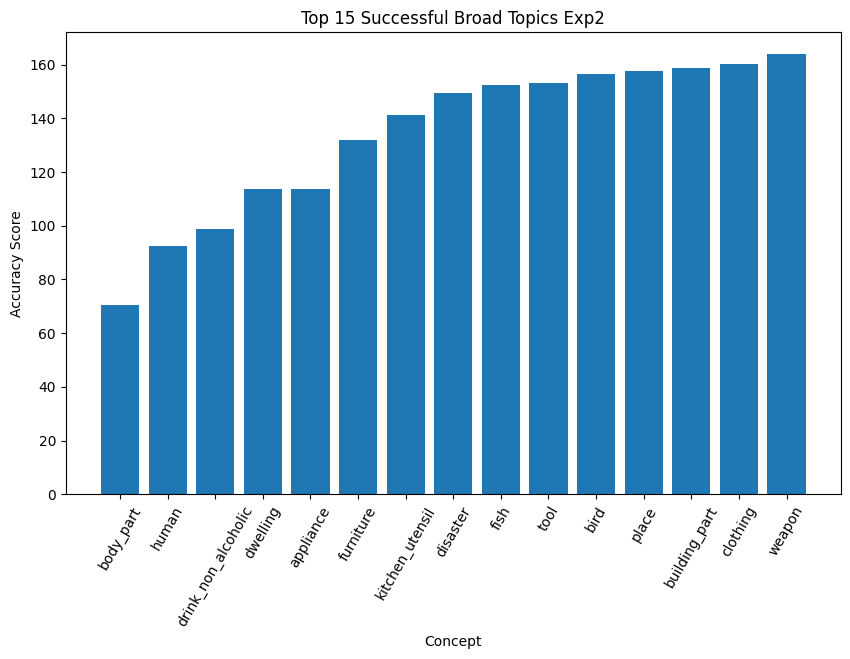

In [ ]:
plot_concepts(successful_topics_2,"Successful ", "Broad Topics ", "Exp2")

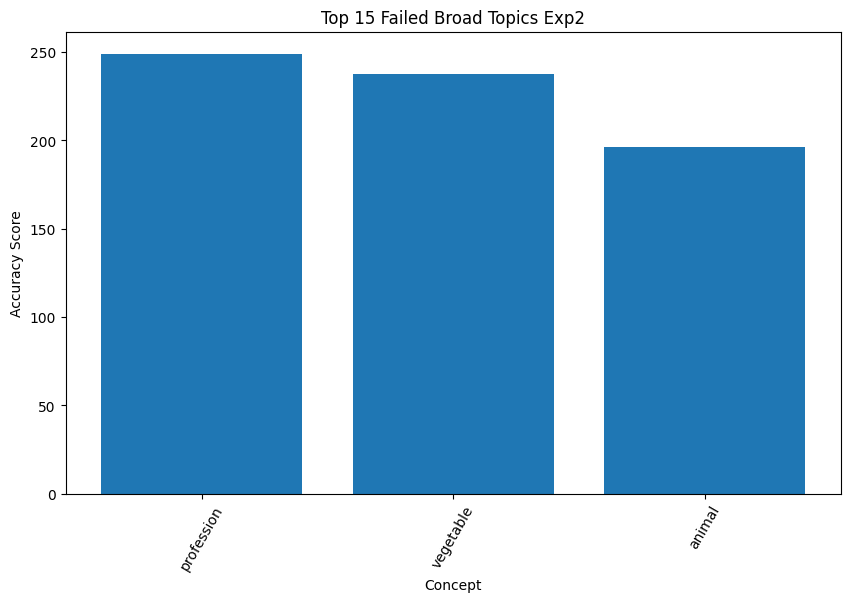

In [ ]:
plot_concepts(failed_topics_2,"Failed ", "Broad Topics ", "Exp2")

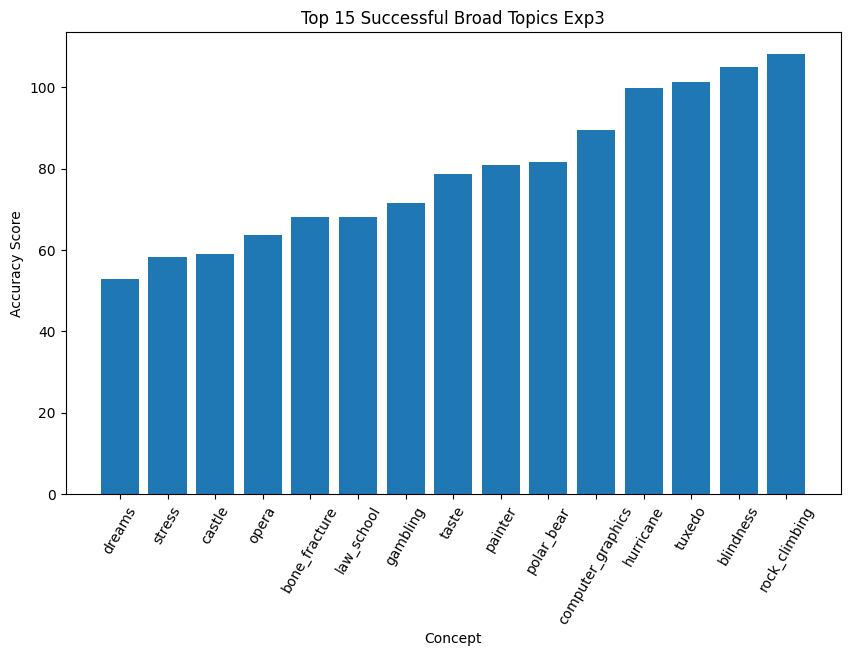

In [ ]:
plot_concepts(successful_topics_3,"Successful ", "Broad Topics ", "Exp3")

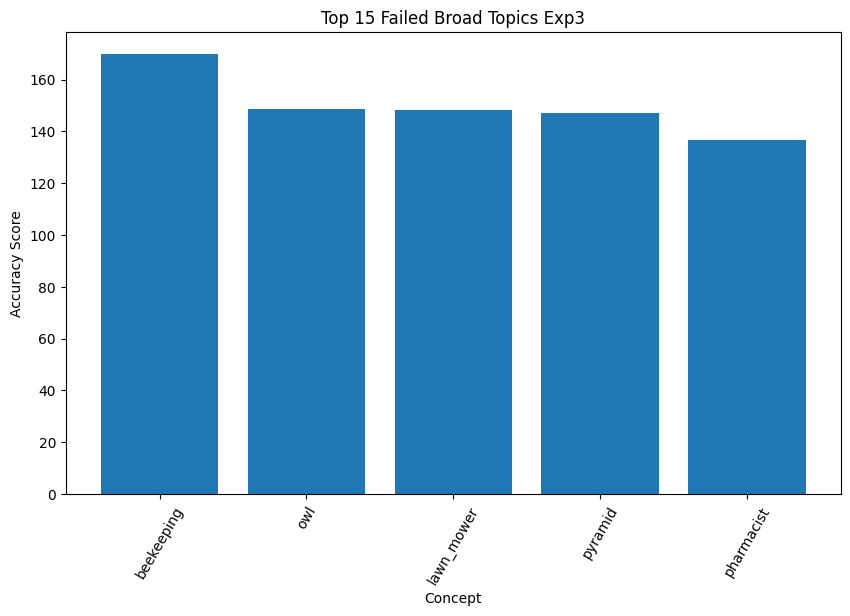

In [ ]:
plot_concepts(failed_topics_3,"Failed ", "Broad Topics ", "Exp3")

*Results*

Keeping in line with the methods used in HW3 & above, to identify the more/less successful topics we computed the average rank for each topic. If the average rank of a topic was lower than half the length of the data, we classified it as successful, otherwise we considered it failed.

Experiments 2 and 3 share similarities in terms of using text passages as stimuli and testing the decoder's ability to decode semantic vectors from brain imaging data. The main difference between the two experiments lies in the nature of the stimuli used. In experiment 2, the stimuli were four-sentence passages that described a concept and provided basic information in a Wikipedia-style format. On the other hand, experiment 3 included narrative passages in addition to the stimuli used in experiment 2.

Despite the similarities, there are some variations in the outcomes of the two experiments. In experiment 2, out of the 24 key passages used, 21 were successfully decoded by the GloVe-based decoder, while 3 failed. The successfully decoded key passages covered a range of topics such as body parts, humans, drinks, furniture, and more. However, the decoder struggled to accurately decode key passages related to professions, vegetables, and animals.

In experiment 3, the outcomes were slightly different. Out of the 24 key passages used, 19 were successfully decoded, while 5 failed. The successful key passages included topics like dreams, stress, castles, taste, and painting. On the other hand, the decoder faced difficulties decoding key passages related to beekeeping, owls, lawn mowers, pyramids, and pharmacists.

It is also interesting to note that on a whole, the accuracy scores of the top 15 successful concepts in experiment 3 were better.

The difference in outcomes between experiment 2 and experiment 3 could be attributed to the addition of narrative passages in the latter. The inclusion of narrative elements might have introduced more complex and diverse linguistic patterns, requiring the decoder to generalize and decode semantic information from a broader range of contexts. This increased complexity may have contributed to the slightly lower success rate in experiment 3 compared to experiment 2.

It is important to keep in mind that in both cases, the decoder was trained on individual words, and tested on both sets of sentences. This step-up in the complexity of the task indicates that on the whole, teh results are impressive.

Overall, both experiments demonstrated the decoder's ability to decode semantic vectors from brain imaging data based on textual stimuli. However, the specific stimuli used in each experiment, particularly the inclusion of narrative passages in experiment 3, led to slightly different outcomes, with experiment 2 yielding a higher success rate.



# Part 2 - Semi-structured Tasks


## Part A
> Training the decoder on both GloVe and BERT for sentence representations

The sentence representations with BERT

In [ ]:
ranks_semi_bert, avgs_semi_bert = train_decoder(fmri_exp2, sentences_exp2_bert, 0, True)

Average Score of Fold 1.0 is: 78.33
Average Score of Fold 2.0 is: 200.92
Average Score of Fold 3.0 is: 121.75
Average Score of Fold 4.0 is: 115.67
Average Score of Fold 5.0 is: 80.67
Average Score of Fold 6.0 is: 86.67
Average Score of Fold 7.0 is: 113.92
Average Score of Fold 8.0 is: 129.08
Average Score of Fold 9.0 is: 121.58
Average Score of Fold 10.0 is: 169.25
Average Score of Fold 11.0 is: 103.25
Average Score of Fold 12.0 is: 85.92
Average Score of Fold 13.0 is: 146.42
Average Score of Fold 14.0 is: 71.0
Average Score of Fold 15.0 is: 190.58
Average Score of Fold 16.0 is: 99.42
Average Score of Fold 17.0 is: 118.42
Average Score of Fold 18.0 is: 116.5
Average Score of Fold 19.0 is: 102.5
Average Score of Fold 20.0 is: 101.75
Average Score of Fold 21.0 is: 113.5
Average Score of Fold 22.0 is: 122.92
Average Score of Fold 23.0 is: 103.33
Average Score of Fold 24.0 is: 139.92
Average Score of Fold 25.0 is: 86.17
Average Score of Fold 26.0 is: 139.0
Average Score of Fold 27.0 is: 59

Successful Key Passages are : {'tool': 65.125, 'insect': 66.75, 'kitchen_utensil': 79.062, 'fish': 87.0, 'body_part': 94.125, 'fruit': 98.688, 'human': 99.2, 'vegetable': 99.312, 'appliance': 102.875, 'furniture': 104.812, 'weapon': 106.688, 'clothing': 107.812, 'building_part': 115.188, 'bird': 118.375, 'disaster': 119.75, 'animal': 126.375, 'landscape': 130.125, 'dwelling': 132.0, 'music': 133.0, 'crime': 140.875, 'drink_non_alcoholic': 148.812, 'profession': 153.438}
Number of Succesful Key Passages: 22
Average Rank of Succesful Topics: 110.42668181818182

Failed Key Passages are : {'place': 203.062, 'vehicles_transport': 202.062}
Number of Failed Key Passages: 2
Average Rank of Failed Topics: 202.562


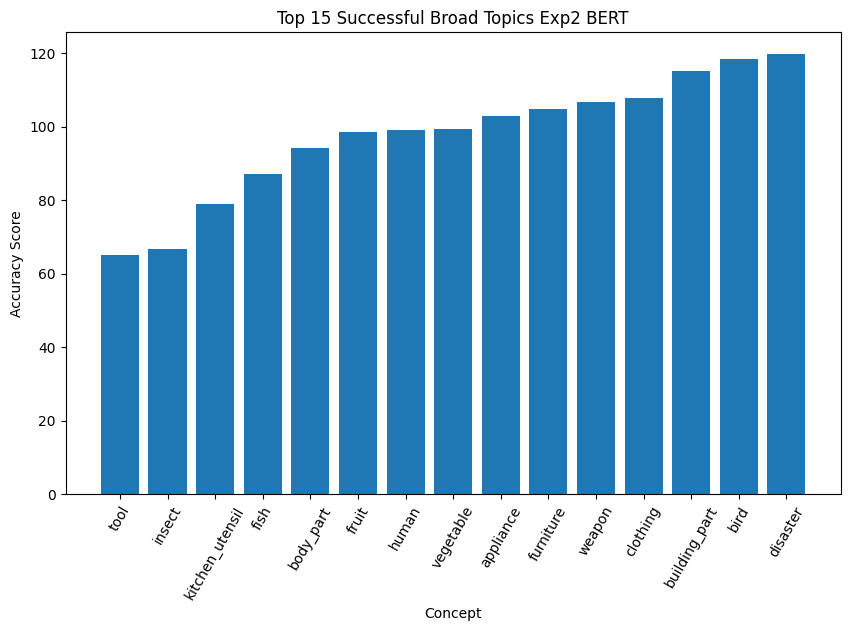

In [ ]:
successful_topics_semi_bert, failed_topics_semi_bert = successful_failed_topics(data_exp2, ranks_semi_bert)
plot_concepts(successful_topics_semi_bert, "Successful ", "Broad Topics ", "Exp2 BERT")

In [ ]:
ranks_semi_exp2, avgs_semi_exp2 = train_decoder(fmri_exp2, vectors_exp2, 0 , True)

Average Score of Fold 1.0 is: 140.17
Average Score of Fold 2.0 is: 166.75
Average Score of Fold 3.0 is: 108.92
Average Score of Fold 4.0 is: 175.17
Average Score of Fold 5.0 is: 143.0
Average Score of Fold 6.0 is: 143.08
Average Score of Fold 7.0 is: 153.25
Average Score of Fold 8.0 is: 127.83
Average Score of Fold 9.0 is: 104.67
Average Score of Fold 10.0 is: 129.0
Average Score of Fold 11.0 is: 108.0
Average Score of Fold 12.0 is: 100.75
Average Score of Fold 13.0 is: 129.33
Average Score of Fold 14.0 is: 73.83
Average Score of Fold 15.0 is: 168.17
Average Score of Fold 16.0 is: 74.92
Average Score of Fold 17.0 is: 147.17
Average Score of Fold 18.0 is: 108.58
Average Score of Fold 19.0 is: 140.67
Average Score of Fold 20.0 is: 137.67
Average Score of Fold 21.0 is: 120.5
Average Score of Fold 22.0 is: 201.0
Average Score of Fold 23.0 is: 110.33
Average Score of Fold 24.0 is: 157.08
Average Score of Fold 25.0 is: 165.5
Average Score of Fold 26.0 is: 178.92
Average Score of Fold 27.0 is

Successful Key Passages are : {'drink_non_alcoholic': 80.562, 'furniture': 81.25, 'dwelling': 86.625, 'human': 88.467, 'body_part': 89.312, 'building_part': 101.312, 'tool': 114.562, 'appliance': 116.438, 'insect': 120.25, 'kitchen_utensil': 128.625, 'fruit': 129.625, 'place': 132.5, 'animal': 139.625, 'disaster': 140.562, 'bird': 142.688, 'fish': 143.812, 'landscape': 151.938, 'weapon': 153.562, 'crime': 157.562, 'vegetable': 166.812, 'vehicles_transport': 181.438, 'clothing': 183.375}
Number of Succesful Key Passages: 22
Average Rank of Succesful Topics: 128.67736363636365

Failed Key Passages are : {'profession': 229.875, 'music': 207.0}
Number of Failed Key Passages: 2
Average Rank of Failed Topics: 218.4375


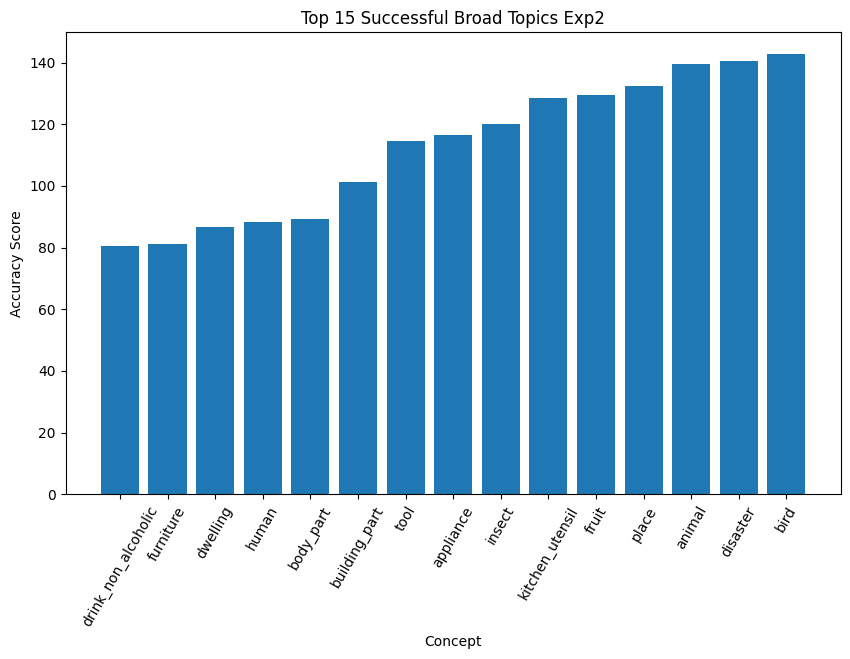

In [ ]:
successful_topics_semi_exp2, failed_topics_semi_exp2 = successful_failed_topics(data_exp2, ranks_semi_exp2)
plot_concepts(successful_topics_semi_exp2, "Successful ", "Broad Topics ", "Exp2")

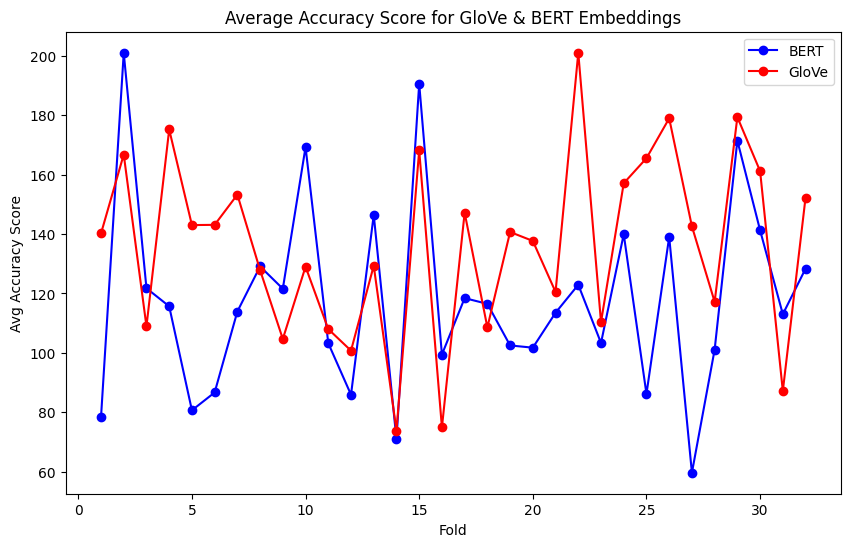

In [ ]:
ranks_bert = list(avgs_semi_bert.values())
ranks_glove = list(avgs_semi_exp2.values())
x = np.arange(1, 33, 1)

plt.figure(figsize=(10,6))
plt.plot(x, ranks_bert, label='BERT', marker='o', color='b')
plt.plot(x, ranks_glove, label='GloVe', marker='o', color='r')
plt.legend()
plt.xlabel('Fold')
plt.ylabel('Avg Accuracy Score')
plt.title('Average Accuracy Score for GloVe & BERT Embeddings')
plt.show()

For this part of the project, we took a pretty similar approach to HW3 & the first part of the Structured Task. We decided to train and evaluate both models in a k-fold cross-validation method with a rank-based accuracy assesment. As there were 384 sentences, we split them into folds of 12 (as opposed to 10 for the words), giving us 32 folds.

Similar to our results with the words, BERT performed similar to the glove embeddings, with both succeeding in 22/24 broad topics. However, just as with the words, BERT's actual accuracy scores indicated slightly better results, both in terms of the topics in which it succeeded and failed, and in the average accuracy score for each fold.

These results, however, are slightly disappointing, as we expected BERT to outperform GloVe when it came to sentences - we know that BERT is supposed to surpass most other models (except perhaps GPT) when it comes to sentences and maintaininng context. We will perofrm a PCA decomposition to the BERT vectors to try and improve the results.
Owing to the computational resources required, we will not perform a cross-validation for the best explained varaince threshold as above, but rather use 0.85 from the outset.

The number of components that explain 85.0 % of the BERT Vectors variance is 66


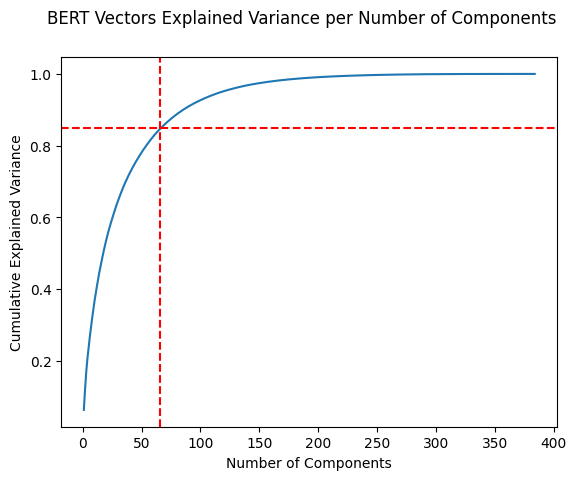

The number of components that explain 85.0 % of the fMRI Data variance is 75


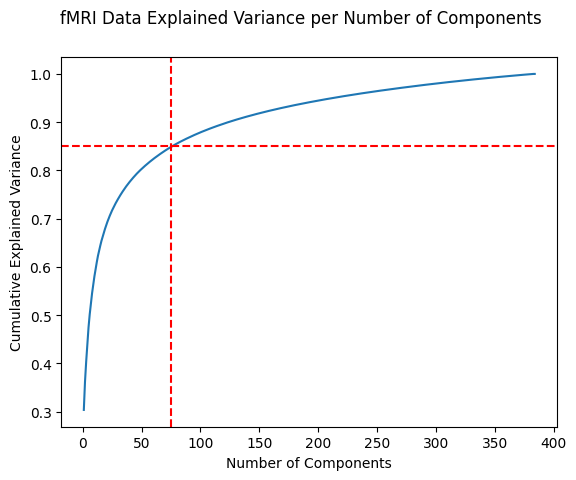

In [ ]:
n_components_bert = pca_cumulative_var("BERT Vectors ", sentences_exp2_bert, 0.85)
n_components_data = pca_cumulative_var("fMRI Data ", fmri_exp2, 0.85)

In [ ]:
pca = PCA(n_components=max(n_components_bert, n_components_data), svd_solver = 'full')
pca.fit(sentences_exp2_bert)
bert_sentences_pca = pca.transform(sentences_exp2_bert)
pca.fit(fmri_exp2)
fmri_exp2_pca = pca.transform(fmri_exp2)
pca.fit(vectors_exp2)
glove_exp2_pca = pca.transform(vectors_exp2)

In [ ]:
ranks_semi_bert, avgs_semi_bert = train_decoder(fmri_exp2_pca, bert_sentences_pca, 0, True)

Average Score of Fold 1.0 is: 62.33
Average Score of Fold 2.0 is: 189.25
Average Score of Fold 3.0 is: 91.75
Average Score of Fold 4.0 is: 121.17
Average Score of Fold 5.0 is: 56.5
Average Score of Fold 6.0 is: 100.0
Average Score of Fold 7.0 is: 115.17
Average Score of Fold 8.0 is: 115.17
Average Score of Fold 9.0 is: 83.83
Average Score of Fold 10.0 is: 168.5
Average Score of Fold 11.0 is: 69.92
Average Score of Fold 12.0 is: 84.25
Average Score of Fold 13.0 is: 169.92
Average Score of Fold 14.0 is: 80.75
Average Score of Fold 15.0 is: 148.83
Average Score of Fold 16.0 is: 125.25
Average Score of Fold 17.0 is: 74.0
Average Score of Fold 18.0 is: 94.17
Average Score of Fold 19.0 is: 109.83
Average Score of Fold 20.0 is: 86.5
Average Score of Fold 21.0 is: 96.0
Average Score of Fold 22.0 is: 135.58
Average Score of Fold 23.0 is: 137.42
Average Score of Fold 24.0 is: 144.17
Average Score of Fold 25.0 is: 103.42
Average Score of Fold 26.0 is: 102.25
Average Score of Fold 27.0 is: 69.83
A

Successful Key Passages are : {'human': 60.133, 'insect': 60.188, 'vegetable': 81.312, 'music': 83.062, 'landscape': 87.562, 'fruit': 89.312, 'clothing': 90.938, 'furniture': 91.812, 'body_part': 102.375, 'disaster': 104.875, 'tool': 108.062, 'building_part': 108.188, 'appliance': 108.875, 'bird': 110.562, 'crime': 110.688, 'fish': 112.438, 'dwelling': 115.438, 'profession': 120.125, 'place': 120.625, 'drink_non_alcoholic': 129.625, 'animal': 137.562, 'weapon': 140.812, 'kitchen_utensil': 152.875, 'vehicles_transport': 158.938}
Number of Succesful Key Passages: 24
Average Rank of Succesful Topics: 107.76591666666668

Failed Key Passages are : {}
Number of Failed Key Passages: 0


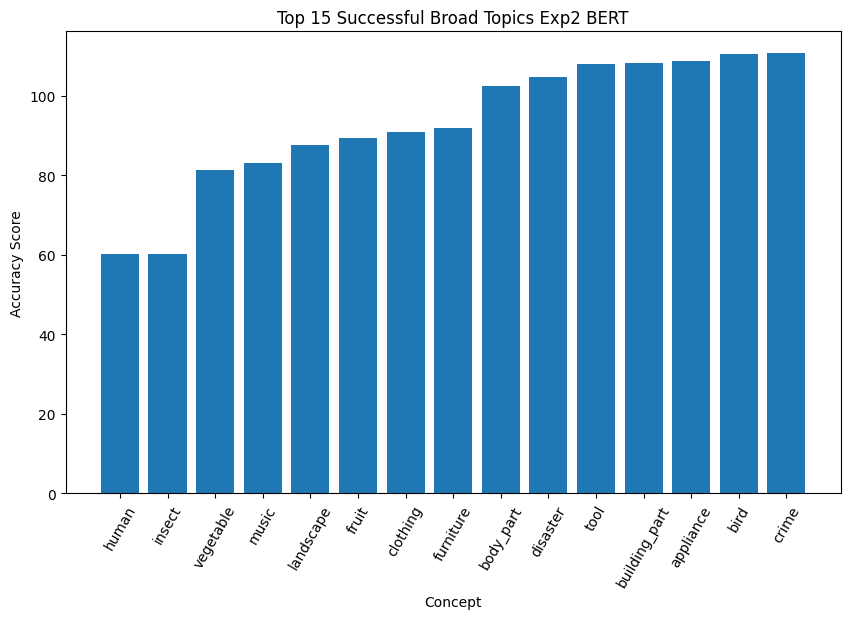

In [ ]:
successful_topics_semi_bert, failed_topics_semi_bert = successful_failed_topics(data_exp2, ranks_semi_bert)
plot_concepts(successful_topics_semi_bert, "Successful ", "Broad Topics ", "Exp2 BERT")

In [ ]:
ranks_semi_exp2, avgs_semi_exp2 = train_decoder(fmri_exp2_pca, glove_exp2_pca, 0 , True)

Average Score of Fold 1.0 is: 54.42
Average Score of Fold 2.0 is: 114.0
Average Score of Fold 3.0 is: 59.33
Average Score of Fold 4.0 is: 89.42
Average Score of Fold 5.0 is: 86.17
Average Score of Fold 6.0 is: 45.92
Average Score of Fold 7.0 is: 75.58
Average Score of Fold 8.0 is: 85.58
Average Score of Fold 9.0 is: 93.0
Average Score of Fold 10.0 is: 152.92
Average Score of Fold 11.0 is: 94.75
Average Score of Fold 12.0 is: 67.42
Average Score of Fold 13.0 is: 87.0
Average Score of Fold 14.0 is: 68.0
Average Score of Fold 15.0 is: 102.83
Average Score of Fold 16.0 is: 119.25
Average Score of Fold 17.0 is: 54.25
Average Score of Fold 18.0 is: 60.25
Average Score of Fold 19.0 is: 91.42
Average Score of Fold 20.0 is: 60.5
Average Score of Fold 21.0 is: 95.0
Average Score of Fold 22.0 is: 116.92
Average Score of Fold 23.0 is: 129.08
Average Score of Fold 24.0 is: 121.17
Average Score of Fold 25.0 is: 93.0
Average Score of Fold 26.0 is: 115.58
Average Score of Fold 27.0 is: 69.58
Average S

Successful Key Passages are : {'human': 32.0, 'crime': 62.312, 'insect': 64.188, 'landscape': 64.625, 'appliance': 71.688, 'drink_non_alcoholic': 72.938, 'animal': 74.312, 'fruit': 78.875, 'fish': 79.5, 'furniture': 82.625, 'place': 84.25, 'music': 84.5, 'vegetable': 86.312, 'building_part': 90.75, 'dwelling': 96.438, 'bird': 97.25, 'kitchen_utensil': 97.938, 'disaster': 103.25, 'profession': 104.0, 'tool': 108.75, 'clothing': 109.25, 'body_part': 110.562, 'vehicles_transport': 117.125, 'weapon': 124.125}
Number of Succesful Key Passages: 24
Average Rank of Succesful Topics: 87.39845833333334

Failed Key Passages are : {}
Number of Failed Key Passages: 0


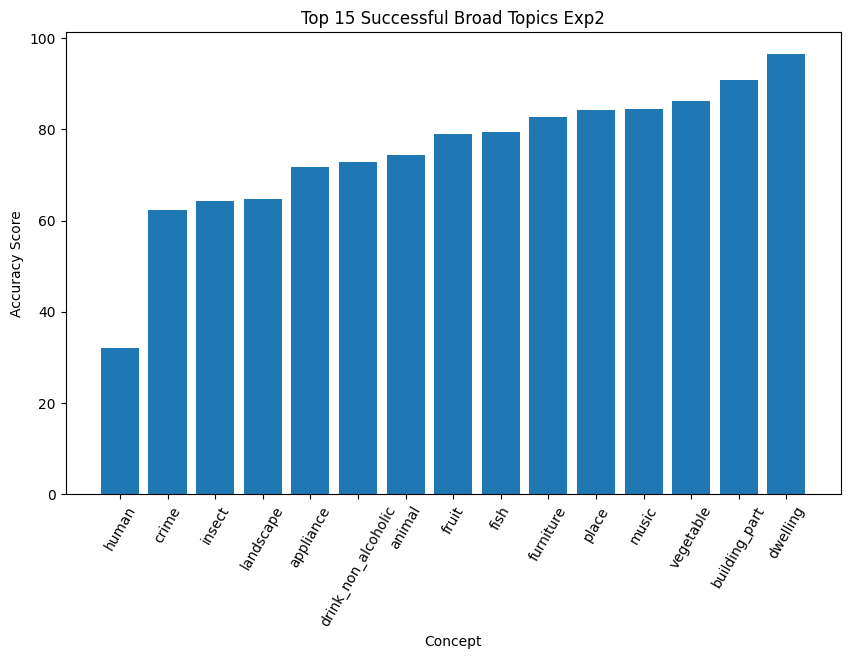

In [ ]:
successful_topics_semi_exp2, failed_topics_semi_exp2 = successful_failed_topics(data_exp2, ranks_semi_exp2)
plot_concepts(successful_topics_semi_exp2, "Successful ", "Broad Topics ", "Exp2")

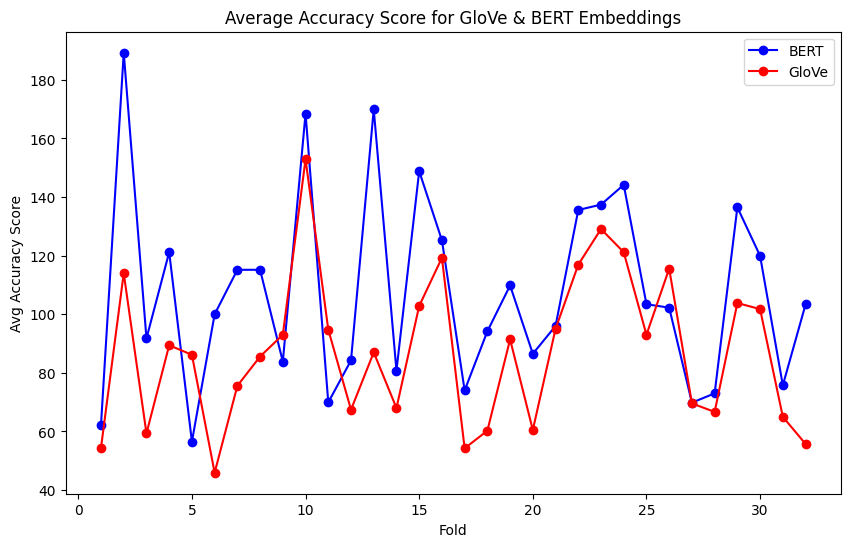

In [ ]:
ranks_bert = list(avgs_semi_bert.values())
ranks_glove = list(avgs_semi_exp2.values())
x = np.arange(1, 33, 1)

plt.figure(figsize=(10,6))
plt.plot(x, ranks_bert, label='BERT', marker='o', color='b')
plt.plot(x, ranks_glove, label='GloVe', marker='o', color='r')
plt.legend()
plt.xlabel('Fold')
plt.ylabel('Avg Accuracy Score')
plt.title('Average Accuracy Score for GloVe & BERT Embeddings')
plt.show()

These results are the opposite of what was expected - although both models improved significantly, GloVe outperformed BERT in terms of accuracy. Although this is surprising, it indicates that GloVe is also a very good model, much better than we thought. Additionally, we can attribute the results to the manner of evaluation - although theorectically, BERT is better at maintain context across sentences, the nature of this task still relates to each sentence as if it were a single word - by averaging across all words in the sentence and taking a single-vector representation of a sentence, it effectively is relating to the sentence as if it were a single word. This perhaps could be the reason that GloVe and BERT performed similarly across all tasks, whether sentences or words. We would expect to see a more significant difference in next-word prediction tasks.

### Don't use

In [ ]:
# ignore for now, huge model that eats all of the RAM
#del outputs
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

inputs = tokenizer(sentences, return_tensors="pt", padding=True)
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
vectors_bert = last_hidden_states[:,1,:].detach().numpy()

In [ ]:
thresholds = [0.75, 0.8, 0.85, 0.9]
for threshold in thresholds:
  print(f'--------------------------- PCA Threshold: {threshold} -----------------------------------------')
  n_components_bert = pca_cumulative_var("Bert Vectors ", embeddings, threshold, cv=True)
  #n_components_data = pca_cumulative_var("fMRI Data ", fmri_exp2, threshold, cv=True)
  #n_components_glove = pca_cumulative_var("GloVe Vectors ", vectors_exp2, threshold, cv=True)
  pca = PCA(n_components=n_components_bert, svd_solver = 'full')
  pca.fit(embeddings)
  bert_pca = pca.transform(embeddings)
  pca.fit(data)
  data_pca = pca.transform(data)
  pca.fit(vectors_exp2)
  glove_pca = pca.transform(vectors_exp2)
  trained_bert = learn_decoder(data_pca, bert_pca)
  trained_glove = learn_decoder(data_pca, glove_pca)
  test_exp2_bert = calculate_rank_sentences(trained_bert, fmri_exp2, vectors_exp2, concepts_exp2)
  test_exp2_glove = calculate_rank_sentences(trained_glove, fmri_exp2, vectors_exp2, concepts_exp2)
  print('')
  print(f'---BERT---')
  successful_topics_3, failed_topics_3 = successful_failed_topics(data_exp2, test_exp3_bert)
  print(f'---GloVe---')
  successful_topics_3, failed_topics_3 = successful_failed_topics(data_exp2, test_exp3_glove)
  print('')
  print('')

In [ ]:
pca = PCA(n_components=70, svd_solver = 'full')

#PCA bert
pca.fit(embeddings)
bert_pca = pca.transform(embeddings)
pca.fit(vectors_exp2)
glove_pca = pca.transform(vectors_exp2)
pca.fit(fmri_exp2)
data_pca = pca.transform(fmri_exp2)

In [ ]:
bert_encoder = learn_decoder(fmri_exp2, embeddings)
glove_encoder = learn_decoder(fmri_exp2, vectors_exp2)

In [ ]:
trained_bert = learn_decoder(data_pca, bert_pca)
trained_glove = learn_decoder(data_pca, glove_pca)

In [ ]:
test_exp3_bert = calculate_rank_sentences(trained_bert, data_pca, glove_pca, concepts_exp2)
test_exp3_extracts = calculate_rank_sentences(trained_glove, data_pca, glove_pca, concepts_exp2)

In [ ]:
sum(test_exp3_bert.values()) / len(test_dict)

In [ ]:
successful_topics_3, failed_topics_3 = successful_failed_topics(data_exp3, test_exp3_bert)
plot_concepts(successful_topics_3,"Successful ", "Broad Topics ", "Exp3")

In [ ]:
successful_topics_3_extracts,failed_topics_3_extracts =successful_failed_topics(data_exp3,test_exp3_extracts)
plot_concepts(successful_topics_3_extracts,"Successful ", "Broad Topics ", "Exp3")

## Part B
> Build a brain-encoder model

In [ ]:
def run_regression(neural_data, x, xT, xTx):
  warnings.filterwarnings("ignore")
  voxel_r2s = []
  significant = []
  cosine_similarities = []
  significant_similarities = []
  p = x.shape[1]
  n = neural_data.shape[1]
  for i in tqdm(range(neural_data.shape[0])):
    y = neural_data[i]
    b = np.matmul(xT, y)
    lse = np.matmul(xTx, b)
    Y_hat = np.matmul(x, lse)
    Y_mean = y.mean()
    SSR = sum((Y_hat - Y_mean)**2)
    #SSres = sum((y-Y_hat)**2)
    SST = sum((y-Y_mean)**2)
    #r2 = 1-((SSres/(n-p))/(SST/(n-1)))
    r2 = SSR/SST
    voxel_r2s.append(r2)
    sim = cosine_similarity(y, Y_hat)
    cosine_similarities.append(sim)
    if r2 > 0.75:
      significant.append(i)
      significant_similarities.append(sim)
      cosine_similarities.append(cosine_similarity(y, Y_hat))

  print(f' Number of significant voxels: {len(significant)}, which is {100*len(significant)/neural_data.shape[0]}%')
  print(f' Mean Cosine Similarity of Significant Voxels is: {np.mean(significant_similarities)}')
  return voxel_r2s, significant, cosine_similarities

In [ ]:
def regression_analysis(neural_data, word_vectors):
    pivot = np.array(neural_data).T.astype(np.float64)
    x_0 = np.ones(pivot.shape[1]).T
    x = np.insert(word_vectors.astype(np.float64), 0, x_0, axis=1)
    xT = x.T
    a = np.linalg.inv(np.matmul(xT, x))
    voxel_r2s, significant, similarity_scores = run_regression(pivot, x, xT, a)
    return voxel_r2s, significant, similarity_scores

In [ ]:
glove_r2s, glove_significant, glove_predicted = regression_analysis(fmri_exp2, vectors_exp2)

100%|██████████| 185866/185866 [01:25<00:00, 2168.05it/s]

 Number of significant voxels: 179867, which is 96.77240592685052%
 Mean Cosine Similarity of Significant Voxels is: 0.9075469960287155


In [ ]:
bert_r2s, bert_significant, bert_predicted = regression_analysis(fmri_exp2, sentences_exp2_bert)

100%|██████████| 185866/185866 [01:32<00:00, 2008.27it/s]


 Number of significant voxels: 185734, which is 99.92898109390636%
 Mean Cosine Similarity of Significant Voxels is: 0.9971901866827877


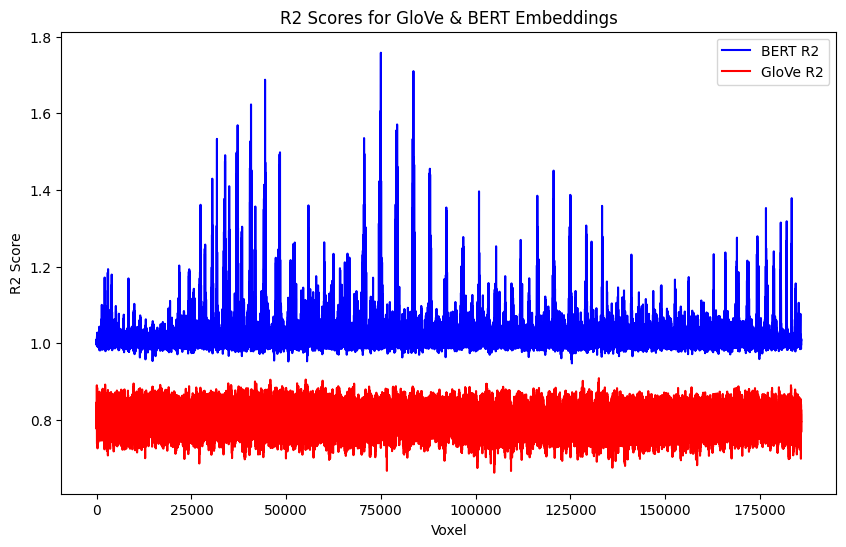

In [ ]:
x = np.arange(1, fmri_exp2.shape[1]+1, 1)
plt.figure(figsize=(10,6))
plt.plot(x, bert_r2s, label='BERT R2', color='b')
plt.plot(x, glove_r2s, label='GloVe R2', color='r')
plt.legend()
plt.xlabel('Voxel')
plt.ylabel('R2 Score')
plt.title('R2 Scores for GloVe & BERT Embeddings')
plt.show()

Although the original results were encouraging, we can see that the R2 scores for the BERT embeddings are greater than 1, which actually indicates a terrible fit. Let's try PCA, and reduce the BERT embeddings to 300 components, to match the dimension of the GloVe embeddings.

In [ ]:
pca = PCA(n_components=300, svd_solver = 'full')
pca.fit(sentences_exp2_bert)
bert_sentences_pca = pca.transform(sentences_exp2_bert)

In [ ]:
bert_r2s, bert_significant, bert_predicted = regression_analysis(fmri_exp2, bert_sentences_pca)

100%|██████████| 185866/185866 [01:31<00:00, 2040.48it/s]


 Number of significant voxels: 175863, which is 94.61816577534353%
 Mean Cosine Similarity of Significant Voxels is: 0.906109687535465


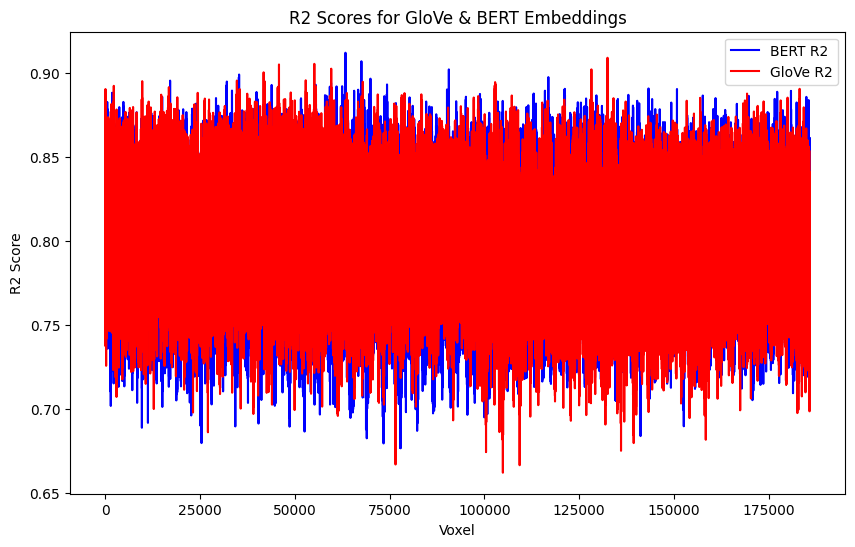

In [ ]:
x = np.arange(1, fmri_exp2.shape[1]+1, 1)
plt.figure(figsize=(10,6))
plt.plot(x, bert_r2s, label='BERT R2', color='b')
plt.plot(x, glove_r2s, label='GloVe R2', color='r')
plt.legend()
plt.xlabel('Voxel')
plt.ylabel('R2 Score')
plt.title('R2 Scores for GloVe & BERT Embeddings')
plt.show()

We can see that the PCA has had a positive impact on the results. For both embeddings, the predicted vectors have an average similarity score of 0.9, and while 96.77% of voxels were deemed significant for the GloVe model, 94.62% were significant for the BERT model. We believe that owing to the success of both models, the high prediction similarity and the high number of relevant voxels, that brain-encoding models are successful and produce significant results. The small difference in the number of significant voxels may refelct a number of different factors, both neural, linguistic and the manner in which the models encode, and thus further research would be required to account for this difference, which is beyond the scope of this research.

# Unstructured Task


**To Do - In Descending Order of Importance**


1) Run Debiasing on words from that came out us very biased in the analysis part

2) Evaualte debiasing success by re-running above analyses

3) Take from HW3 the word pattern prediction task with gender specific words, see if debiasing impacts the results

**Probably Not Happening**

4) Analysing the sentences and seeing if there is anything interesting there that might exhibit bias which we could use

5) Taking bert and glove embeddings of races and using steps 1-3 above to calculate racial biases

6) Fix Soft Debias

**Almost Definintely Not Happening**

7) Fix cluster plottings with PCA/TSNE

8) Statistical Analysis

9) Fix regression part of Semi-Structured

**Deadline - Monday starting on report, Tuesday finishing report**

Whatever is not done by then is not happening

## Utility Functions

In [ ]:
def create_gender_vector(embedding='glove', male=True):
  male_list = ['he', 'son', 'his', 'him', 'father', 'man', 'boy', 'himself', 'male', 'brother', 'sons', 'fathers', 'men', 'boys', 'males', 'brothers', 'uncle', 'uncles', 'nephew', 'nephews']
  female_list = ['she', 'daughter', 'hers', 'her', 'mother', 'woman', 'girl', 'herself', 'female', 'sister', 'daughters', 'mothers', 'women', 'girls', 'females', 'sisters', 'aunt', 'aunts', 'niece', 'nieces']
  words = male_list if male else female_list
  if embedding == 'glove':
    vectors = get_glove_embeddings(words)
  else:
    inputs = tokenizer(words, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    vectors = last_hidden_states[:,1,:].detach().numpy()
  return np.mean(vectors, axis=0)

In [ ]:
def find_vector_from_word(word, vectors):
    return vectors[np.where(concepts==word)[0][0]]

In [ ]:
def get_neutral_extremtities(distances, threshold):
    sorted_distances = sorted(distances)
    count = len(distances)
    index = int(count * threshold)

    lower = sorted_distances[:index]
    upper = sorted_distances[-index:]

    return max(lower), min(upper)

In [ ]:
def neutral_dist(male, female, vectors, indices, bins=10, threshold=0.05):
    distances = []
    neutral_vector = np.zeros(vectors.shape[1])
    for idx in indices:
      dist_m = cosine_similarity(male, vectors[idx])
      dist_f = cosine_similarity(female, vectors[idx])
      neutral_vector += vectors[idx]
      distances.append(dist_m-dist_f)
    neutral_vector = neutral_vector/vectors.shape[0]
    sns.displot(distances, bins=bins, kde=True).set(xlabel='Word Similarity Difference Between Genders', title='Distribution of Neutral Word Similarity Measures')
    l, u = get_neutral_extremtities(distances, threshold)
    return l, u, neutral_vector

In [ ]:
def calculate_gender_bias(word, male, female):
    dist_m = cosine_similarity(male, word)
    dist_f = cosine_similarity(female, word)
    return dist_m, dist_f

In [ ]:
def create_bias_dict(male, female, vectors, lower, upper, concepts):
      biases = {}
      for i, word in enumerate(concepts):
          word_data = {}
          dist_male, dist_female = calculate_gender_bias(vectors[i], male, female)
          diff = dist_male - dist_female
          if diff < lower or diff > upper:
            bias = round(diff, 8)
            bias_to = 'Male' if bias > 0 else 'Female'
          else:
            bias = 'Unbiased'
            bias_to = 'None'
          items = [('Score', round(diff, 8)), ('Bias', bias),  ('Biased To', bias_to)]
          word_data.update(items)
          biases[word] = word_data
      return biases

In [ ]:
def prediction_analysis(preds, vectors, word_list, male_label, female_label, n_clusters, centroids):
    pred_dict = {}
    for i, word in enumerate(word_list):
        if preds[i] == male_label:
          label = 'Male'
        elif preds[i] == female_label:
          label = 'Female'
        else:
          label = 'Neutral'
        pred_dict[word] = label
    print(pred_dict)
    plt.figure(figsize=(8, 6))
    for i in range(n_clusters):
        cluster_points = vectors[preds == i]
        if i == male_label:
          plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Male Cluster")
        elif i == female_label:
          plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Female Cluster")
        else:
          plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Neutral Cluster")
    for i, txt in enumerate(word_list):
        plt.annotate(txt, (vectors[i, 0], vectors[i,1]))
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', label='Centroids')
    plt.title(f'K-Means Clustering of Predicted Vectors')
    plt.legend()
    plt.show()


In [ ]:
def run_kmeans_analysis(male, female, neutral, vectors, concepts, reduction=None, embedding='Glove', to_predict=None, words_to_predict=None, show_names=False):
    kmeans = KMeans(n_clusters=3, init=[male, female, neutral]).fit(vectors)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    male_cluster = []
    female_cluster = []
    for i, label in enumerate(labels):
        if label == 0:
          male_cluster.append(concepts[i])
        elif label == 1:
          female_cluster.append(concepts[i])
    print(f'The Words Clustered with Males are: {male_cluster}')
    print(f'The Words Clustered with Females are: {female_cluster}')

    #Reduce Dimension to Plot
    if reduction == 'tsne':
      tsne = TSNE(n_components=2)
      plot_vectors = tsne.fit_transform(vectors)
    elif reduction == 'pca':
      pca = PCA(n_components=2)
      plot_vectors = pca.fit_transform(vectors)
    else:
      plot_vectors = vectors

    # Plot the clusters
    cluster_names = ['Male', 'Female', 'Neutral']
    plt.figure(figsize=(8, 6))
    for i, name in enumerate(cluster_names):
        cluster_points = plot_vectors[labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"{name} Cluster")
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', label='Centroids')
    if show_names:
        for i, txt in enumerate(concepts):
            plt.annotate(txt, (plot_vectors[i, 0], plot_vectors[i,1]))
    plt.title(f'K-Means Clustering of {embedding} Word Vectors')
    plt.legend()
    plt.show()

    if embedding != 'FMRI':
        preds = kmeans.predict(to_predict)
        prediction_analysis(preds, to_predict, words_to_predict, 0, 1, 3, centroids)


In [ ]:
def run_random_kmeans(n_clusters, vectors, concepts, to_predict, words_to_predict, show_names=False):
    concepts = np.array(concepts)
    kmeans = KMeans(n_clusters=n_clusters, init='random', n_init='auto').fit(vectors)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    for i in range(n_clusters):
        exec(f"cluster_{i} = concepts[labels=={i}]")
        exec(f"print('Cluster {i+1}')")
        exec(f"print(cluster_{i})")

    # Plot the clusters
    plt.figure(figsize=(10, 8))
    for i in range(n_clusters):
        cluster_points = vectors[labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {i+1}")
    if show_names:
        for i, txt in enumerate(concepts):
            plt.annotate(txt, (vectors[i, 0], vectors[i,1]))
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', label='Centroids')
    plt.title(f'K-Means Clustering of Word Vectors')
    plt.legend()
    plt.show()

    male_cluster = labels[66]
    female_cluster = labels[67]
    preds = kmeans.predict(to_predict)
    prediction_analysis(preds, to_predict, words_to_predict, male_cluster, female_cluster, n_clusters, centroids)

In [ ]:
def plot_top_biases(bias_dict, embedding):
  data = {}
  words = []
  bias = []
  gender = []
  for k, v in bias_dict.items():
   if v['Biased To'] != 'None':
    bias.append(abs(v['Bias']))
    words.append(k)
    gender.append(v['Biased To'])
  data.update([('Words', words), ('Bias', bias), ('Gender', gender)])
  order = bias.sort()
  pal = ['blue', 'hotpink']

  sns.barplot(x='Words', y='Bias', data=data, hue='Gender', dodge=False, order=order, palette=pal)
  plt.title(f'Biased Concepts for {embedding} Embedding')
  plt.xticks(rotation=75)
  plt.ylabel("Bias Score")
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

## Data

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

inputs_1 = tokenizer(list(concepts), return_tensors="pt", padding=True)
outputs_1 = model(**inputs_1)
last_hidden_states_1 = outputs_1.last_hidden_state
concepts_bert = last_hidden_states_1[:,1,:].detach().numpy()
inputs_2 = tokenizer(['male', 'female'], return_tensors="pt", padding=True)
outputs_2 = model(**inputs_2)
last_hidden_states_2 = outputs_2.last_hidden_state
man_woman = last_hidden_states_2[:,1,:].detach().numpy()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
concepts_glove = get_glove_embeddings(concepts)

In [ ]:
# extracting relevant features for analysis. Note that indices89 & 90 (lady and king) are non gender-neutral
neutral_indices = [3, 4, 5, 6, 8, 9, 12, 13, 14, 17, 18, 21, 22, 23, 25, 27, 31, 33, 35, 37, 39, 43, 42, 44, 45, 46, 47, 48, 51, 52, 53, 55, 58, 60, 65, 66, 67, 70, 71, 72, 73, 78, 79, 81, 83, 84, 87, 91, 92, 93, 94, 95, 97, 98, 100, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 118, 119, 120, 121, 126, 127, 128, 129, 131, 132, 133, 135, 136, 139, 140, 141, 42, 143, 144, 145, 147, 148, 149, 150, 151, 152, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 174, 176, 177, 178, 179]
ba_concept_indices = [0, 1, 2, 7, 10, 11, 15, 16, 19, 20, 24, 26, 28, 29, 30, 32, 34, 36, 38, 40, 41, 49, 50, 54, 56, 57, 59, 61, 62, 63, 64, 68, 69, 74, 75, 76, 77, 80, 82, 85, 86, 88, 89, 90, 96, 99, 101, 104, 114, 117, 122, 123, 124, 125, 130, 134, 137, 138, 146, 153, 154, 155, 157, 171, 173, 175]
ba_concepts = []
ba_fmri_data = []
ba_bert = []
ba_glove = []
for index in ba_concept_indices:
    ba_concepts.append(concepts[index])
    ba_fmri_data.append(data_c[index])
    ba_bert.append(concepts_bert[index])
    ba_glove.append(concepts_glove[index])

ba_fmri = np.array(ba_fmri_data)
ba_bert = np.array(ba_bert)
ba_glove = np.array(ba_glove)

In [ ]:
word_list = ['engineer', 'lawyer', 'soldier','nurse', 'dancer', 'housekeeper', 'loyal', 'honest', 'strong', 'maternal', 'attractive', 'tidy']
kmeans_glove = get_glove_embeddings(word_list)

In [ ]:
inputs_3 = tokenizer(word_list, return_tensors="pt", padding=True)
outputs_3 = model(**inputs_3)
last_hidden_states_3 = outputs_3.last_hidden_state
kmeans_bert = last_hidden_states_3[:,1,:].detach().numpy()

In [ ]:
male_bert = man_woman[0]
female_bert = man_woman[1]

In [ ]:
male_bert = create_gender_vector(embedding=model, male=True)
female_bert = create_gender_vector(embedding=model, male=False)

In [ ]:
male_glove = create_gender_vector(embedding='glove', male=True)
female_glove = create_gender_vector(embedding='glove', male=False)

In [ ]:
male_fmri = np.array(fmri_exp2[208], dtype='float64')
female_fmri = np.array(fmri_exp2[380], dtype='float64')

In [ ]:
for i, concept in enumerate(concepts_exp3):
  print(i, concept)

In [ ]:
for i, concept in enumerate(concepts_exp2):
  print(i, concept)

## Bias Analysis

### Language Biases on Single-Word Concepts

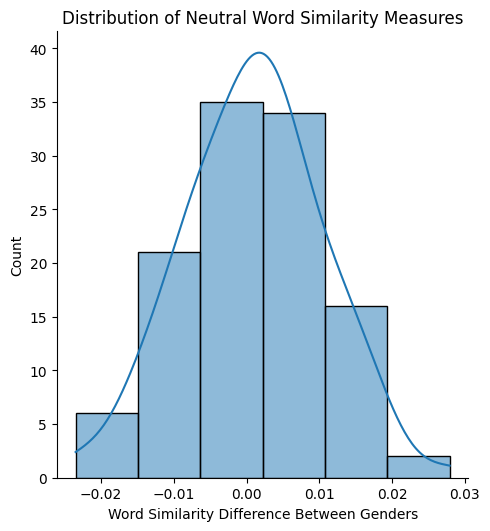

In [ ]:
lower_bert, upper_bert, nv_bert = neutral_dist(male_bert, female_bert, concepts_bert, neutral_indices, bins=6, threshold = 0.1)

In [ ]:
bert_biases = create_bias_dict(male_bert, female_bert, ba_bert, lower_bert, upper_bert, ba_concepts)
bert_biases

{'ability': {'Score': -0.00445194, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'accomplished': {'Score': -0.00290363,
  'Bias': 'Unbiased',
  'Biased To': 'None'},
 'angry': {'Score': 0.01250643, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'art': {'Score': 0.00575182, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'ball': {'Score': 0.0116499, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'bar': {'Score': 0.02559143, 'Bias': 0.02559143, 'Biased To': 'Male'},
 'beer': {'Score': 0.02325495, 'Bias': 0.02325495, 'Biased To': 'Male'},
 'big': {'Score': 0.03853135, 'Bias': 0.03853135, 'Biased To': 'Male'},
 'body': {'Score': 0.00802239, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'brain': {'Score': 0.00571099, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'business': {'Score': 0.00418193, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'carefully': {'Score': -0.01061066, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'charity': {'Score': -0.00916895, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'charming': {'Score':

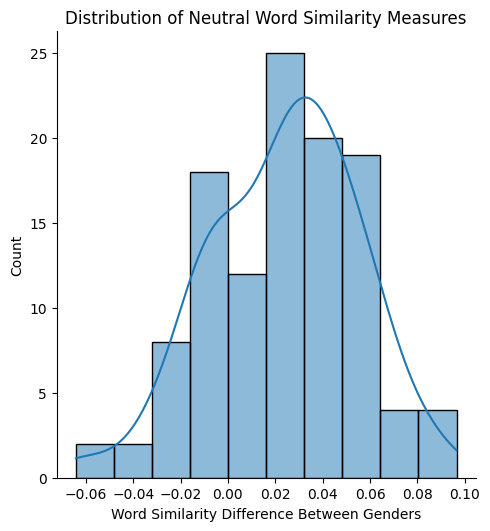

In [ ]:
lower_glove, upper_glove, nv_glove = neutral_dist(male_glove, female_glove, concepts_glove, neutral_indices, bins=10, threshold=0.1)

In [ ]:
glove_biases = create_bias_dict(male_glove, female_glove, ba_glove, lower_glove, upper_glove, ba_concepts)
glove_biases

{'ability': {'Score': 0.02955928, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'accomplished': {'Score': 0.04360571,
  'Bias': 'Unbiased',
  'Biased To': 'None'},
 'angry': {'Score': 0.0379334, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'art': {'Score': 0.01075362, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'ball': {'Score': 0.03900203, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'bar': {'Score': 0.06958032, 'Bias': 0.06958032, 'Biased To': 'Male'},
 'beer': {'Score': 0.05977166, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'big': {'Score': 0.04065448, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'body': {'Score': -0.01352194, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'brain': {'Score': 0.03269987, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'business': {'Score': 0.03231294, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'carefully': {'Score': -0.00016768, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'charity': {'Score': -0.01601948, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'charming': {'Score': 

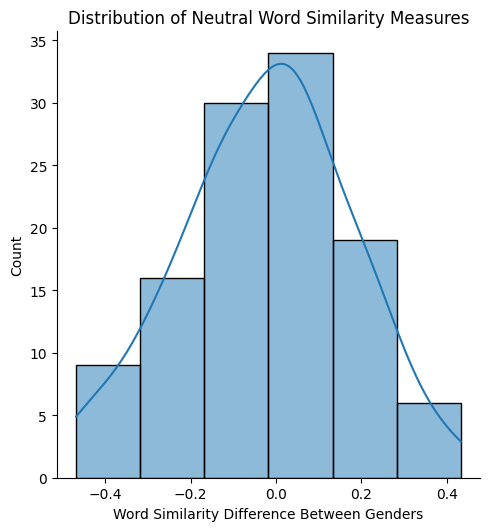

In [ ]:
lower_fmri, upper_fmri, nv_fmri = neutral_dist(male_fmri, female_fmri, data_c, neutral_indices, bins=6, threshold=0.1)

In [ ]:
fmri_biases = create_bias_dict(male_fmri, female_fmri, ba_fmri, lower_fmri, upper_fmri, ba_concepts)
fmri_biases

{'ability': {'Score': -0.1784061, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'accomplished': {'Score': 0.09467794,
  'Bias': 'Unbiased',
  'Biased To': 'None'},
 'angry': {'Score': -0.21798217, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'art': {'Score': -0.02947809, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'ball': {'Score': -0.07607799, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'bar': {'Score': -0.26931603, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'beer': {'Score': -0.21770995, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'big': {'Score': 0.14722258, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'body': {'Score': -0.08154074, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'brain': {'Score': -0.21684136, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'business': {'Score': 0.39925216, 'Bias': 0.39925216, 'Biased To': 'Male'},
 'carefully': {'Score': -0.12288356, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'charity': {'Score': -0.04230778, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'charming': {'S

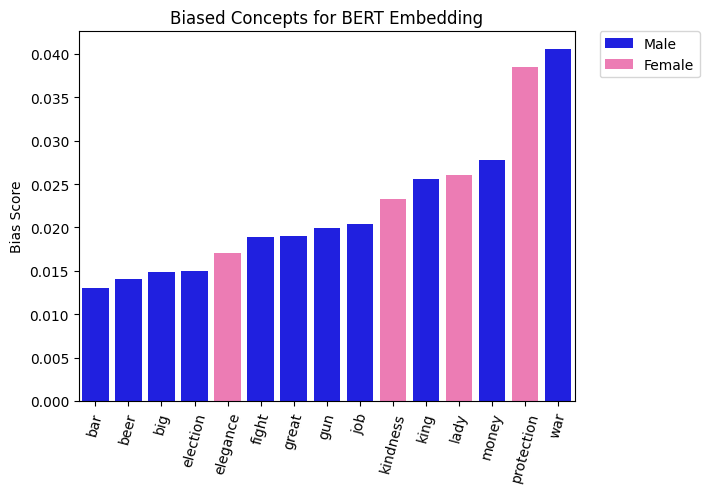

In [ ]:
plot_top_biases(bert_biases, 'BERT')

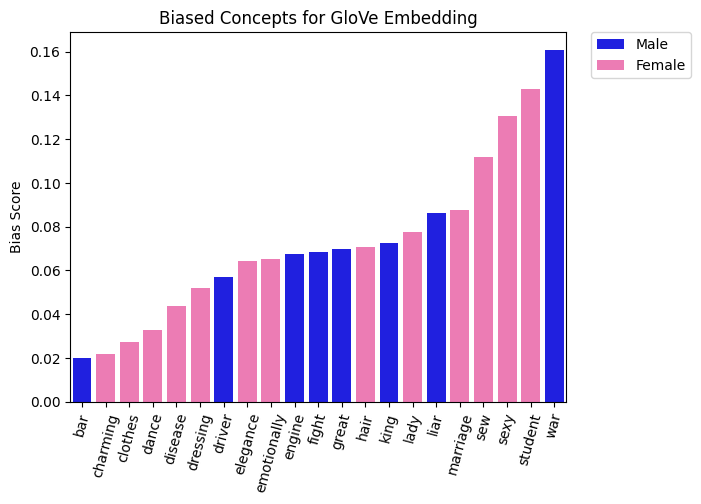

In [ ]:
plot_top_biases(glove_biases, 'GloVe')

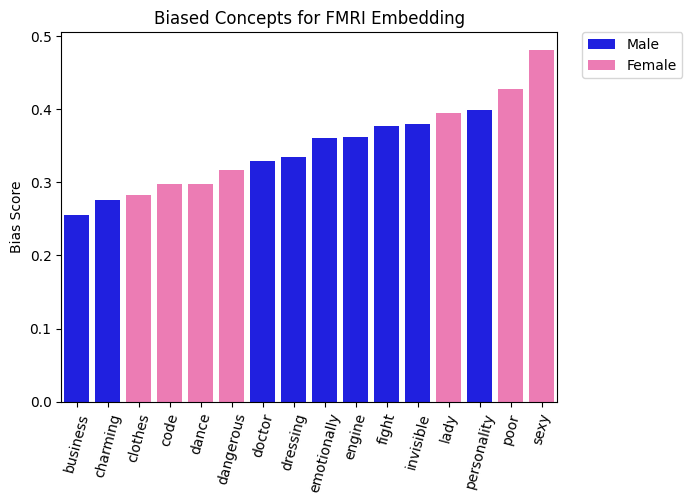

In [ ]:
plot_top_biases(fmri_biases, 'FMRI')

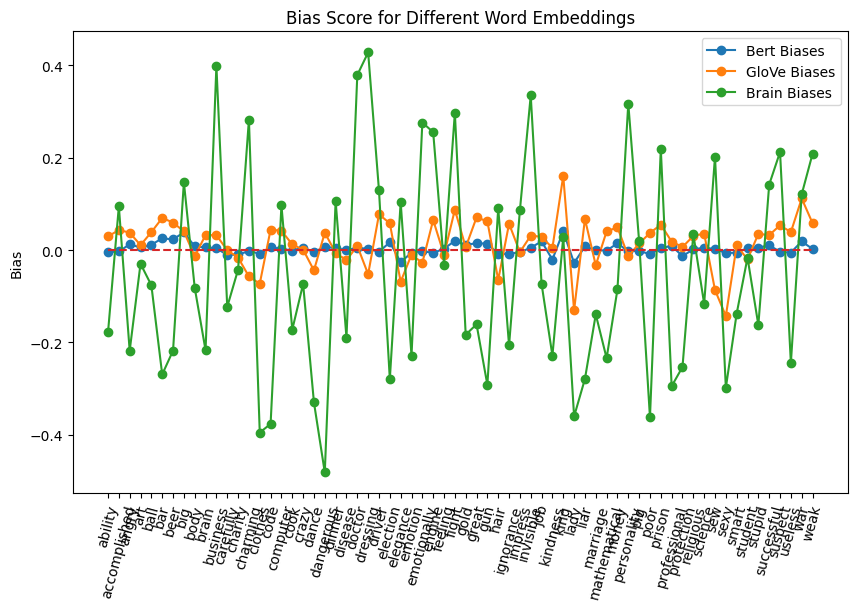

In [ ]:
bb = list(wd['Score'] for wd in bert_biases.values())
gb = list(wd['Score'] for wd in glove_biases.values())
fb = list(wd['Score'] for wd in fmri_biases.values())

plt.figure(figsize=(10,6))
plt.plot(ba_concepts, bb, marker='o', label='Bert Biases')
plt.plot(ba_concepts, gb, marker='o', label='GloVe Biases')
plt.plot(ba_concepts, fb, marker='o', label='Brain Biases')
plt.plot(ba_concepts, np.zeros(len(ba_concepts)), linestyle='--')
plt.legend()
plt.xticks(rotation=75)
plt.ylabel('Bias')
plt.title('Bias Score for Different Word Embeddings')
plt.show()

### Fixed Clustering Analysis

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


The Words Clustered with Males are: ['king']
The Words Clustered with Females are: ['clothes', 'dressing', 'hair', 'lady', 'marriage', 'sexy']


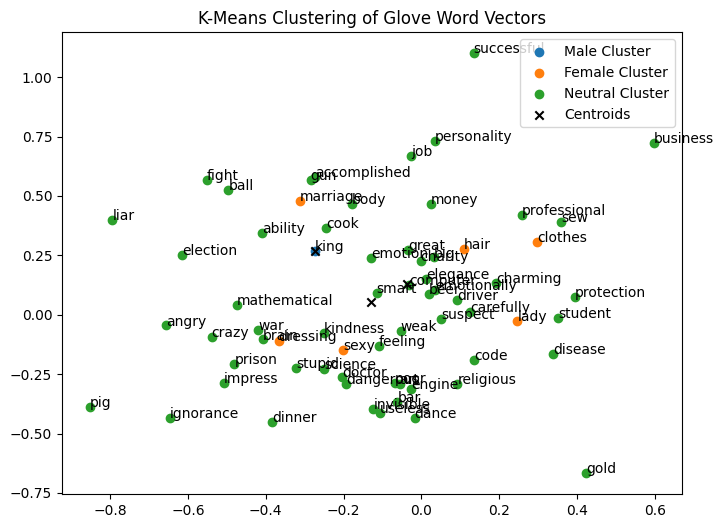

{'engineer': 'Neutral', 'lawyer': 'Neutral', 'soldier': 'Neutral', 'nurse': 'Neutral', 'dancer': 'Neutral', 'housekeeper': 'Neutral', 'loyal': 'Neutral', 'honest': 'Neutral', 'strong': 'Neutral', 'maternal': 'Neutral', 'attractive': 'Neutral', 'tidy': 'Neutral'}


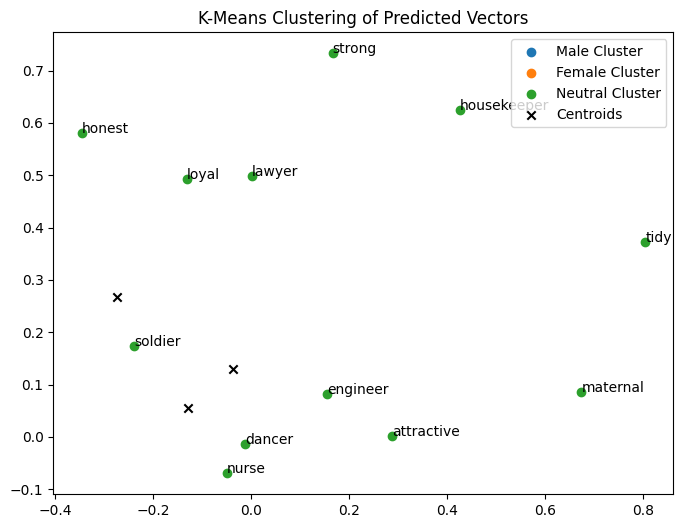

In [ ]:
run_kmeans_analysis(male_glove, female_glove, nv_glove, ba_glove, ba_concepts, reduction=None, embedding='Glove', to_predict=kmeans_glove, words_to_predict=word_list, show_names=True)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


The Words Clustered with Males are: ['ball', 'bar', 'beer', 'big', 'body', 'brain', 'code', 'crazy', 'doctor', 'dressing', 'feeling', 'fight', 'gold', 'great', 'gun', 'invisible', 'job', 'king', 'money', 'pig', 'student', 'stupid', 'suspect', 'useless', 'weak']
The Words Clustered with Females are: ['ability', 'accomplished', 'angry', 'carefully', 'charming', 'cook', 'dangerous', 'disease', 'driver', 'emotion', 'emotionally', 'engine', 'ignorance', 'impress', 'kindness', 'lady', 'liar', 'mathematical', 'personality', 'poor', 'protection', 'sexy', 'smart']


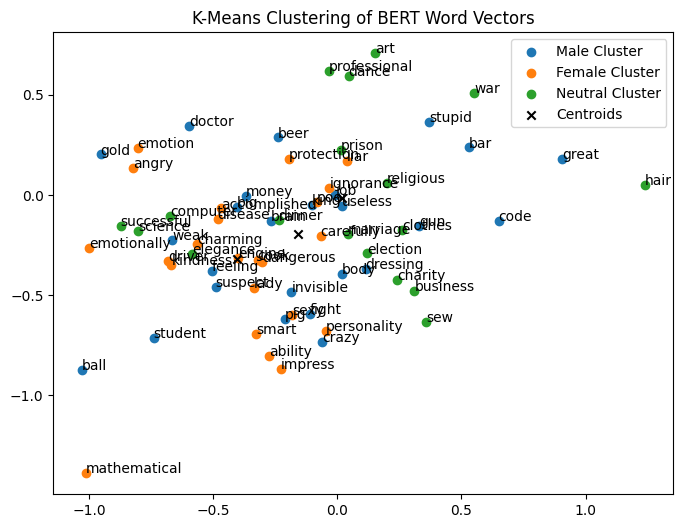

{'engineer': 'Neutral', 'lawyer': 'Neutral', 'soldier': 'Male', 'nurse': 'Female', 'dancer': 'Neutral', 'housekeeper': 'Female', 'loyal': 'Female', 'honest': 'Female', 'strong': 'Female', 'maternal': 'Female', 'attractive': 'Female', 'tidy': 'Female'}


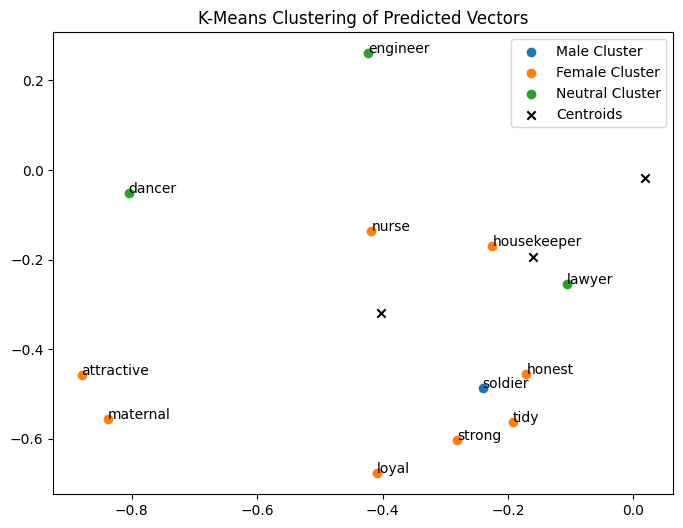

In [ ]:
run_kmeans_analysis(male_bert, female_bert, nv_bert, ba_bert, ba_concepts, reduction=None, embedding='BERT', to_predict=kmeans_bert, words_to_predict=word_list, show_names=True)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


The Words Clustered with Males are: ['accomplished', 'art', 'big', 'business', 'charming', 'dinner', 'doctor', 'dressing', 'driver', 'elegance', 'emotionally', 'engine', 'fight', 'hair', 'impress', 'invisible', 'personality', 'pig', 'prison', 'religious', 'sew', 'successful', 'suspect', 'war', 'weak']
The Words Clustered with Females are: ['dance']


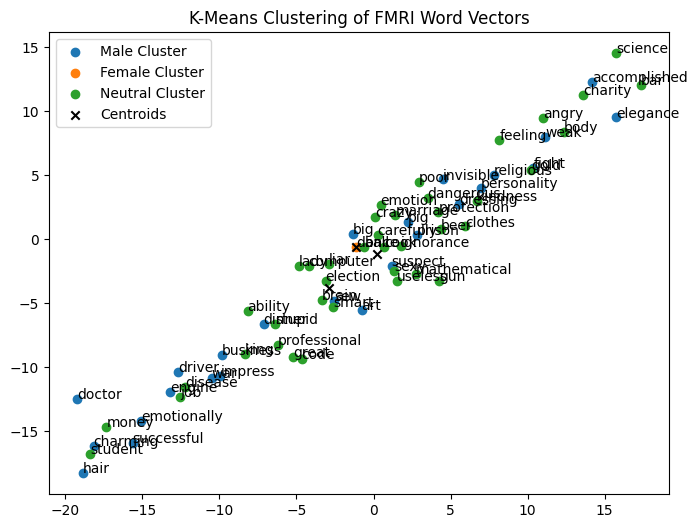

In [ ]:
run_kmeans_analysis(male_fmri, female_fmri, nv_fmri, ba_fmri, ba_concepts, reduction=None, embedding='FMRI', show_names=True)

### Random Clustering Analysis

In [ ]:
def kmeans_cv(vectors):
    proportions = []
    n_list = [5, 8, 10, 15, 20, 25, 30]
    for n in n_list:
      sims = []
      for i in tqdm(range(10000)):
          kmeans = KMeans(n_clusters=n, init='random', n_init='auto').fit(vectors)
          labels = kmeans.labels_
          centroids = kmeans.cluster_centers_
          outcome = 1 if labels[66] == labels[67] else 0
          sims.append(outcome)
      print(f'Proportion of Runs Putting Male & Female in Same Cluster for {n} Clusters: {round(np.mean(sims), 5)*100}%')
      proportions.append(round(np.mean(sims), 5)*100)
    return proportions

In [ ]:
ba_bert_added = np.append(ba_bert, np.reshape(male_bert, (1, 768)), axis=0)
ba_bert_added = np.append(ba_bert_added, np.reshape(female_bert, (1, 768)), axis=0)
ba_glove_added = np.append(ba_glove, np.reshape(male_glove, (1, 300)), axis=0)
ba_glove_added = np.append(ba_glove_added, np.reshape(female_glove, (1, 300)), axis=0)
ba_concepts_added = ba_concepts.copy()
ba_concepts_added.append('Male')
ba_concepts_added.append('Female')

In [ ]:
glove_mean_prop = kmeans_cv(ba_glove_added)

100%|██████████| 10000/10000 [01:05<00:00, 152.48it/s]


Proportion of Runs Putting Male & Female in Same Cluster for 5 Clusters: 62.160000000000004%


100%|██████████| 10000/10000 [01:03<00:00, 158.08it/s]


Proportion of Runs Putting Male & Female in Same Cluster for 8 Clusters: 64.99000000000001%


100%|██████████| 10000/10000 [01:04<00:00, 154.49it/s]


Proportion of Runs Putting Male & Female in Same Cluster for 10 Clusters: 66.32000000000001%


100%|██████████| 10000/10000 [01:04<00:00, 154.86it/s]


Proportion of Runs Putting Male & Female in Same Cluster for 15 Clusters: 66.63%


100%|██████████| 10000/10000 [01:03<00:00, 158.55it/s]


Proportion of Runs Putting Male & Female in Same Cluster for 20 Clusters: 62.53999999999999%


100%|██████████| 10000/10000 [01:05<00:00, 151.75it/s]


Proportion of Runs Putting Male & Female in Same Cluster for 25 Clusters: 54.84%


100%|██████████| 10000/10000 [01:09<00:00, 144.42it/s]

Proportion of Runs Putting Male & Female in Same Cluster for 30 Clusters: 50.17%


In [ ]:
bert_mean_prop = kmeans_cv(ba_bert_added)

100%|██████████| 10000/10000 [01:46<00:00, 94.17it/s] 


Proportion of Runs Putting Male & Female in Same Cluster for 5 Clusters: 97.1%


100%|██████████| 10000/10000 [01:39<00:00, 100.47it/s]


Proportion of Runs Putting Male & Female in Same Cluster for 8 Clusters: 97.25%


100%|██████████| 10000/10000 [01:43<00:00, 96.67it/s]


Proportion of Runs Putting Male & Female in Same Cluster for 10 Clusters: 97.45%


100%|██████████| 10000/10000 [01:51<00:00, 90.06it/s]


Proportion of Runs Putting Male & Female in Same Cluster for 15 Clusters: 96.65%


100%|██████████| 10000/10000 [01:49<00:00, 90.99it/s]


Proportion of Runs Putting Male & Female in Same Cluster for 20 Clusters: 94.53%


100%|██████████| 10000/10000 [01:55<00:00, 86.68it/s]


Proportion of Runs Putting Male & Female in Same Cluster for 25 Clusters: 90.29%


100%|██████████| 10000/10000 [01:58<00:00, 84.51it/s]

Proportion of Runs Putting Male & Female in Same Cluster for 30 Clusters: 85.39%


Cluster 1
['big' 'charity' 'money']
Cluster 2
['charming' 'elegance' 'lady' 'sexy']
Cluster 3
['protection']
Cluster 4
['angry' 'pig']
Cluster 5
['religious']
Cluster 6
['business' 'great' 'job' 'professional' 'successful']
Cluster 7
['sew']
Cluster 8
['dance' 'impress' 'Female']
Cluster 9
['ball']
Cluster 10
['disease']
Cluster 11
['election']
Cluster 12
['driver' 'smart']
Cluster 13
['kindness']
Cluster 14
['crazy' 'dangerous' 'ignorance' 'liar' 'stupid' 'useless']
Cluster 15
['poor' 'prison' 'weak']
Cluster 16
['gun' 'suspect']
Cluster 17
['emotion' 'emotionally' 'feeling' 'personality']
Cluster 18
['king']
Cluster 19
['cook' 'dinner']
Cluster 20
['code' 'computer' 'engine']
Cluster 21
['hair']
Cluster 22
['fight' 'war']
Cluster 23
['mathematical' 'science']
Cluster 24
['student']
Cluster 25
['marriage']
Cluster 26
['gold']
Cluster 27
['bar' 'beer']
Cluster 28
['clothes' 'dressing']
Cluster 29
['ability' 'accomplished' 'art' 'carefully' 'doctor' 'invisible' 'Male']
Cluster 30
['body

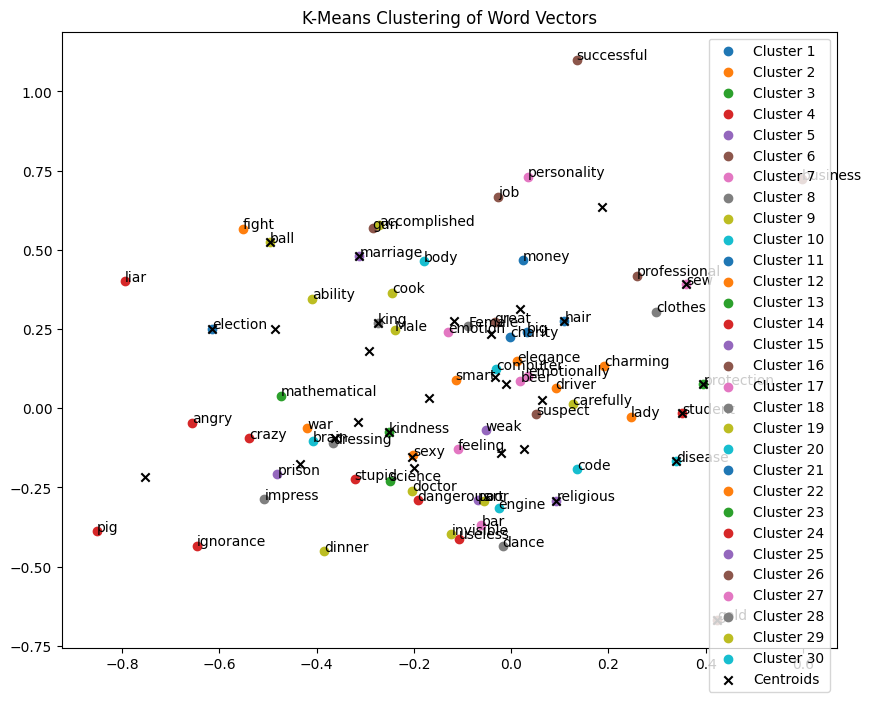

{'engineer': 'Neutral', 'lawyer': 'Male', 'soldier': 'Neutral', 'nurse': 'Male', 'dancer': 'Female', 'housekeeper': 'Male', 'loyal': 'Male', 'honest': 'Neutral', 'strong': 'Neutral', 'maternal': 'Male', 'attractive': 'Neutral', 'tidy': 'Male'}


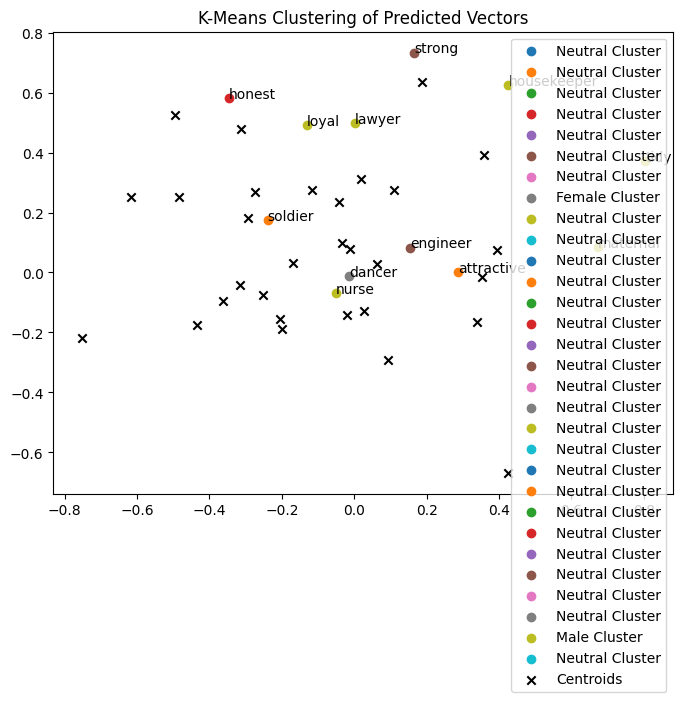

In [ ]:
run_random_kmeans(30, ba_glove_added, ba_concepts_added, kmeans_glove, word_list, True)

Cluster 1
['elegance']
Cluster 2
['clothes' 'dinner']
Cluster 3
['gun' 'job' 'pig']
Cluster 4
['gold']
Cluster 5
['business' 'charity' 'prison' 'professional' 'protection']
Cluster 6
['crazy' 'dangerous' 'great' 'invisible' 'king' 'mathematical' 'money'
 'poor' 'sexy' 'stupid']
Cluster 7
['ability' 'dressing' 'emotion' 'emotionally' 'feeling']
Cluster 8
['charming' 'kindness' 'lady']
Cluster 9
['angry']
Cluster 10
['beer']
Cluster 11
['code']
Cluster 12
['big']
Cluster 13
['marriage' 'religious']
Cluster 14
['art' 'dance' 'science']
Cluster 15
['war']
Cluster 16
['fight' 'ignorance' 'successful' 'useless' 'weak' 'Male' 'Female']
Cluster 17
['doctor' 'personality' 'student']
Cluster 18
['election']
Cluster 19
['hair']
Cluster 20
['liar']
Cluster 21
['carefully']
Cluster 22
['body']
Cluster 23
['impress']
Cluster 24
['smart']
Cluster 25
['bar' 'sew']
Cluster 26
['ball' 'cook']
Cluster 27
['driver' 'engine']
Cluster 28
['suspect']
Cluster 29
['brain' 'computer' 'disease']
Cluster 30
['acc

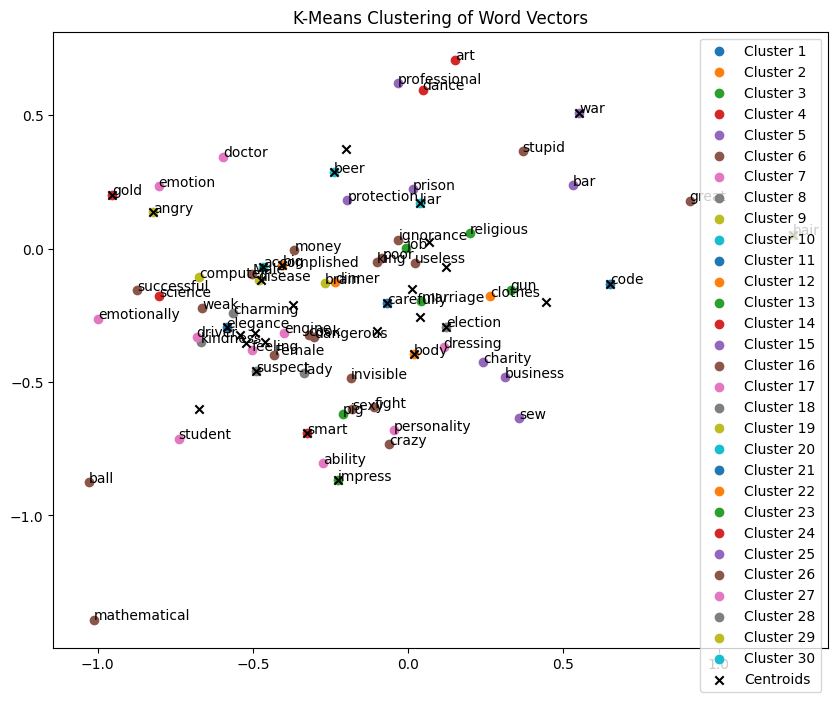

{'engineer': 'Neutral', 'lawyer': 'Neutral', 'soldier': 'Neutral', 'nurse': 'Neutral', 'dancer': 'Neutral', 'housekeeper': 'Male', 'loyal': 'Male', 'honest': 'Neutral', 'strong': 'Neutral', 'maternal': 'Male', 'attractive': 'Neutral', 'tidy': 'Male'}


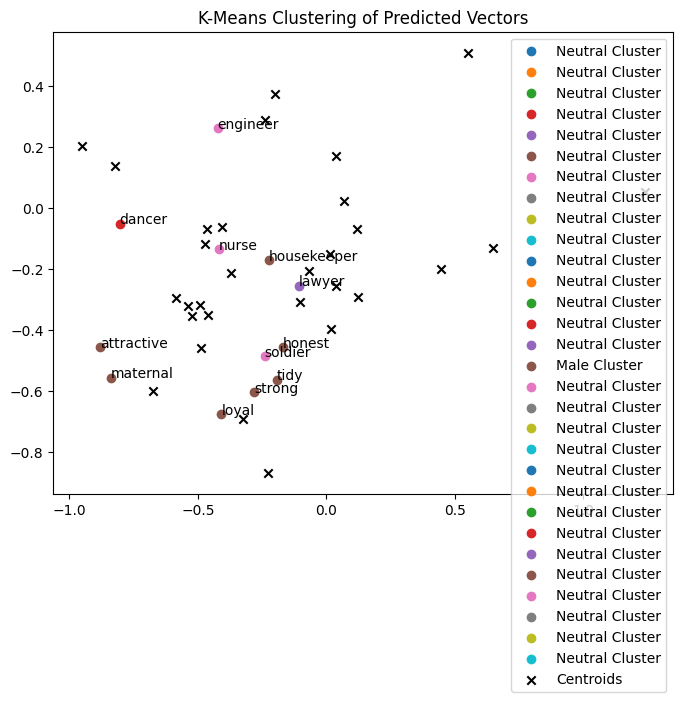

In [ ]:
run_random_kmeans(30, ba_bert_added, ba_concepts_added, kmeans_bert, word_list, True)

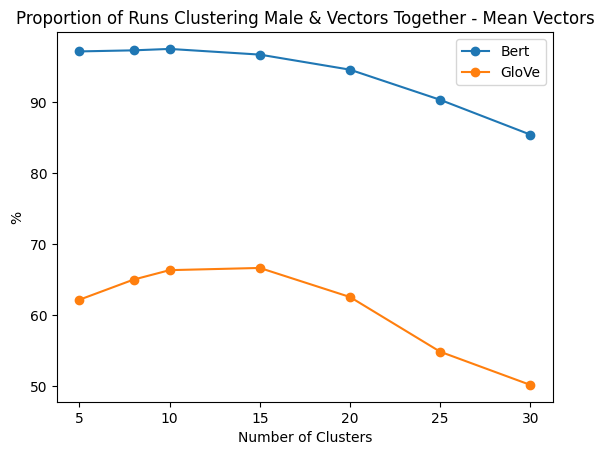

In [ ]:
n_its = [5, 8, 10, 15, 20, 25, 30]

plt.plot(n_its, bert_mean_prop, marker='o', label='Bert')
plt.plot(n_its, glove_mean_prop, marker='o', label='GloVe')
plt.legend()
plt.ylabel('%')
plt.xlabel('Number of Clusters')
plt.title('Proportion of Runs Clustering Male & Vectors Together - Mean Vectors')
plt.show()

In [ ]:
mf = get_glove_embeddings(['male', 'female'])
male_glove_single = mf[0]
female_glove_single = mf[1]
ba_glove_added_single = np.append(ba_glove, np.reshape(male_glove_single, (1, 300)), axis=0)
ba_glove_added_single = np.append(ba_glove_added_single, np.reshape(female_glove_single, (1, 300)), axis=0)

In [ ]:
male_bert_single = man_woman[0]
female_bert_single = man_woman[1]
ba_bert_added_single = np.append(ba_bert, np.reshape(male_bert_single, (1, 768)), axis=0)
ba_bert_added_single = np.append(ba_bert_added_single, np.reshape(female_bert_single, (1, 768)), axis=0)

In [ ]:
glove_single_prop = kmeans_cv(ba_glove_added_single)
bert_single_prop = kmeans_cv(ba_bert_added_single)

100%|██████████| 10000/10000 [01:07<00:00, 148.86it/s]


Proportion of Runs Putting Male & Female in Same Cluster for 5 Clusters: 99.53999999999999%


100%|██████████| 10000/10000 [01:04<00:00, 155.77it/s]


Proportion of Runs Putting Male & Female in Same Cluster for 8 Clusters: 99.69%


100%|██████████| 10000/10000 [01:04<00:00, 154.03it/s]


Proportion of Runs Putting Male & Female in Same Cluster for 10 Clusters: 99.51%


100%|██████████| 10000/10000 [01:04<00:00, 153.92it/s]


Proportion of Runs Putting Male & Female in Same Cluster for 15 Clusters: 99.49%


100%|██████████| 10000/10000 [01:02<00:00, 159.50it/s]


Proportion of Runs Putting Male & Female in Same Cluster for 20 Clusters: 98.85000000000001%


100%|██████████| 10000/10000 [01:02<00:00, 160.47it/s]


Proportion of Runs Putting Male & Female in Same Cluster for 25 Clusters: 98.47%


100%|██████████| 10000/10000 [01:03<00:00, 157.30it/s]


Proportion of Runs Putting Male & Female in Same Cluster for 30 Clusters: 96.94%


100%|██████████| 10000/10000 [01:50<00:00, 90.81it/s]


Proportion of Runs Putting Male & Female in Same Cluster for 5 Clusters: 99.79%


100%|██████████| 10000/10000 [01:44<00:00, 95.78it/s]


Proportion of Runs Putting Male & Female in Same Cluster for 8 Clusters: 99.22%


100%|██████████| 10000/10000 [01:44<00:00, 95.66it/s]


Proportion of Runs Putting Male & Female in Same Cluster for 10 Clusters: 98.54%


100%|██████████| 10000/10000 [01:47<00:00, 92.87it/s]


Proportion of Runs Putting Male & Female in Same Cluster for 15 Clusters: 97.52%


100%|██████████| 10000/10000 [01:39<00:00, 100.21it/s]


Proportion of Runs Putting Male & Female in Same Cluster for 20 Clusters: 95.32000000000001%


100%|██████████| 10000/10000 [01:38<00:00, 102.02it/s]


Proportion of Runs Putting Male & Female in Same Cluster for 25 Clusters: 93.17%


100%|██████████| 10000/10000 [01:38<00:00, 102.04it/s]

Proportion of Runs Putting Male & Female in Same Cluster for 30 Clusters: 89.14999999999999%


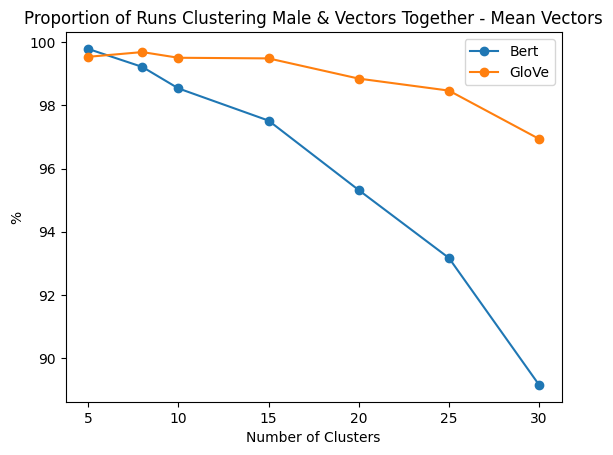

In [ ]:
plt.plot(n_its, bert_single_prop, marker='o', label='Bert')
plt.plot(n_its, glove_single_prop, marker='o', label='GloVe')
plt.legend()
plt.ylabel('%')
plt.xlabel('Number of Clusters')
plt.title('Proportion of Runs Clustering Male & Vectors Together - Mean Vectors')
plt.show()

### Re-run both analyses with BERT & fMRI PCA

In [ ]:
concepts_bert_added = np.append(concepts_bert, np.reshape(male_bert, (1, 768)), axis=0)
concepts_bert_added = np.append(concepts_bert_added, np.reshape(female_bert, (1, 768)), axis=0)

In [ ]:
concepts_bert_added = np.append(concepts_bert_added, kmeans_bert, axis=0)

In [ ]:
fmri_added = np.append(data_c, np.reshape(male_fmri, (1, data_c.shape[1])), axis=0)
fmri_added = np.append(fmri_added, np.reshape(female_fmri, (1, data_c.shape[1])), axis=0)

The number of components that explain 85.0 % of the Bert Vectors variance is 74


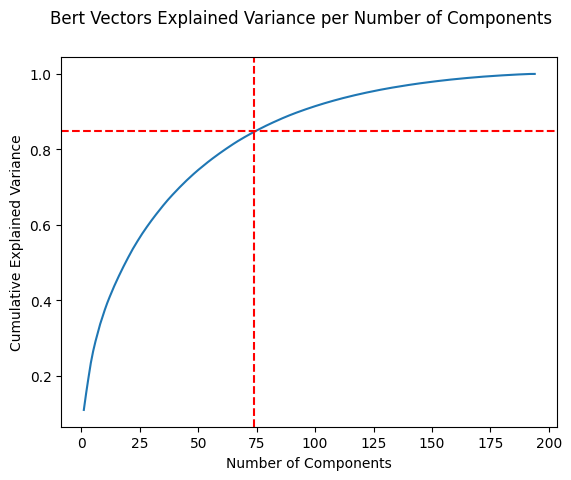

The number of components that explain 85.0 % of the fMRI Data variance is 41


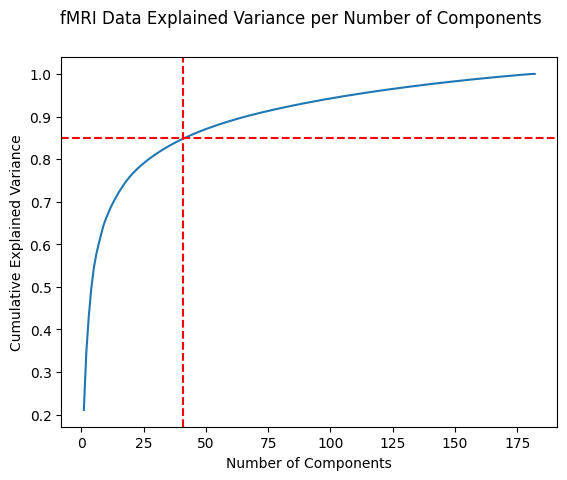

In [ ]:
n_components_bert = pca_cumulative_var("Bert Vectors ", concepts_bert_added, 0.85)
pca = PCA(n_components=n_components_bert, svd_solver = 'full')
pca.fit(concepts_bert_added)
bert_pca = pca.transform(concepts_bert_added)

n_components_fmri = pca_cumulative_var("fMRI Data ", fmri_added, 0.85)
pca = PCA(n_components=n_components_fmri, svd_solver = 'full')
pca.fit(fmri_added)
fmri_pca = pca.transform(fmri_added)

In [ ]:
ba_bert_pca = []
ba_fmri_pca = []
for index in ba_concept_indices:
  ba_bert_pca.append(bert_pca[index])
  ba_fmri_pca.append(fmri_pca[index])
ba_fmri_pca = np.array(ba_fmri_pca)
ba_bert_pca = np.array(ba_bert_pca)

In [ ]:
male_bert_pca = bert_pca[180]
female_bert_pca = bert_pca[181]
test_bert_pca = bert_pca[182:]

In [ ]:
male_fmri_pca = fmri_pca[180]
female_fmri_pca = fmri_pca[181]

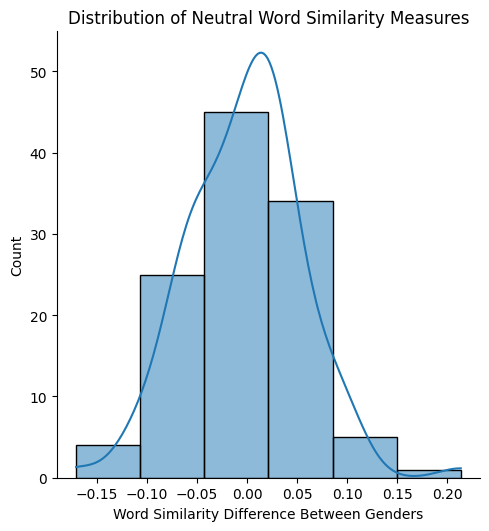

In [ ]:
lower_bert, upper_bert, nv_bert = neutral_dist(male_bert_pca, female_bert_pca, bert_pca, neutral_indices, bins=6, threshold = 0.1)

In [ ]:
bert_biases = create_bias_dict(male_bert_pca, female_bert_pca, ba_bert_pca, lower_bert, upper_bert, ba_concepts)
bert_biases

{'ability': {'Score': -0.03964721, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'accomplished': {'Score': -0.05492308,
  'Bias': 'Unbiased',
  'Biased To': 'None'},
 'angry': {'Score': 0.02845836, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'art': {'Score': 0.01534358, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'ball': {'Score': 0.07471399, 'Bias': 0.07471399, 'Biased To': 'Male'},
 'bar': {'Score': 0.1530511, 'Bias': 0.1530511, 'Biased To': 'Male'},
 'beer': {'Score': 0.16351028, 'Bias': 0.16351028, 'Biased To': 'Male'},
 'big': {'Score': 0.2288391, 'Bias': 0.2288391, 'Biased To': 'Male'},
 'body': {'Score': 0.07812667, 'Bias': 0.07812667, 'Biased To': 'Male'},
 'brain': {'Score': 0.06145876, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'business': {'Score': -0.00316575, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'carefully': {'Score': -0.07635678,
  'Bias': -0.07635678,
  'Biased To': 'Female'},
 'charity': {'Score': -0.10124733, 'Bias': -0.10124733, 'Biased To': 'Female'},
 'charming': {

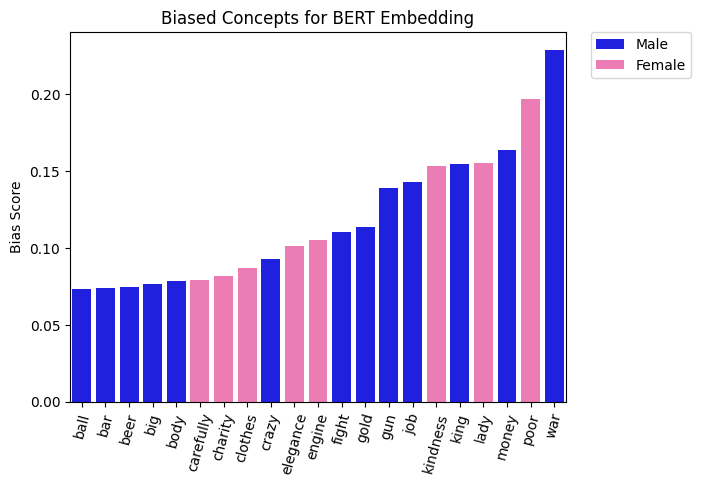

In [ ]:
plot_top_biases(bert_biases, 'BERT')

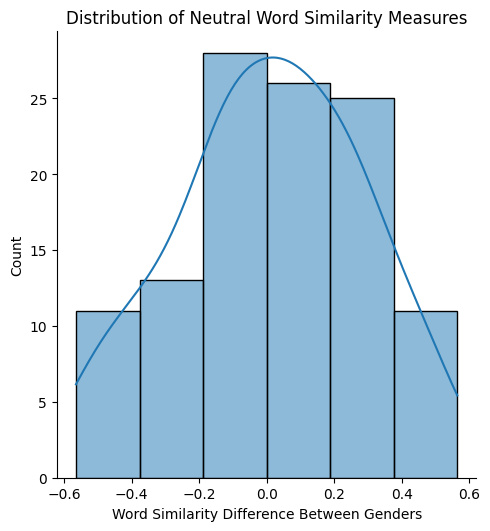

In [ ]:
lower_fmri, upper_fmri, nv_fmri = neutral_dist(male_fmri_pca, female_fmri_pca, fmri_pca, neutral_indices, bins=6, threshold=0.1)

In [ ]:
fmri_biases = create_bias_dict(male_fmri_pca, female_fmri_pca, ba_fmri_pca, lower_fmri, upper_fmri, ba_concepts)
fmri_biases

{'ability': {'Score': -0.24699761, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'accomplished': {'Score': 0.08973175,
  'Bias': 'Unbiased',
  'Biased To': 'None'},
 'angry': {'Score': -0.27181269, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'art': {'Score': -0.02192196, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'ball': {'Score': -0.0284636, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'bar': {'Score': -0.30503381, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'beer': {'Score': -0.24327281, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'big': {'Score': 0.20115397, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'body': {'Score': -0.13602536, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'brain': {'Score': -0.25981298, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'business': {'Score': 0.46930197, 'Bias': 0.46930197, 'Biased To': 'Male'},
 'carefully': {'Score': -0.15432437, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'charity': {'Score': -0.03406505, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'charming': {'S

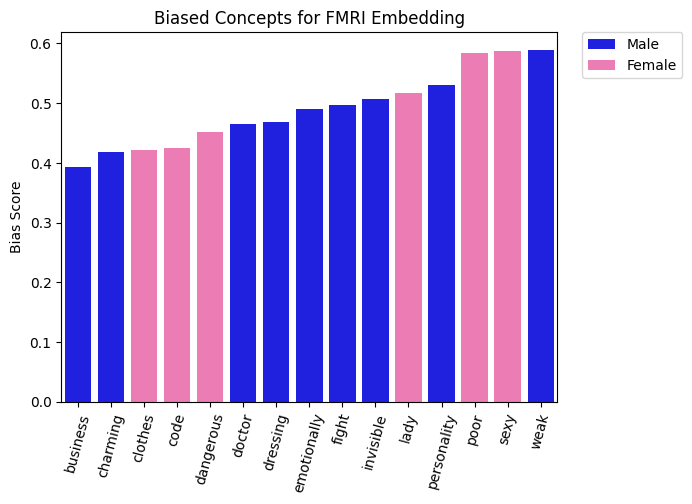

In [ ]:
plot_top_biases(fmri_biases, 'FMRI')

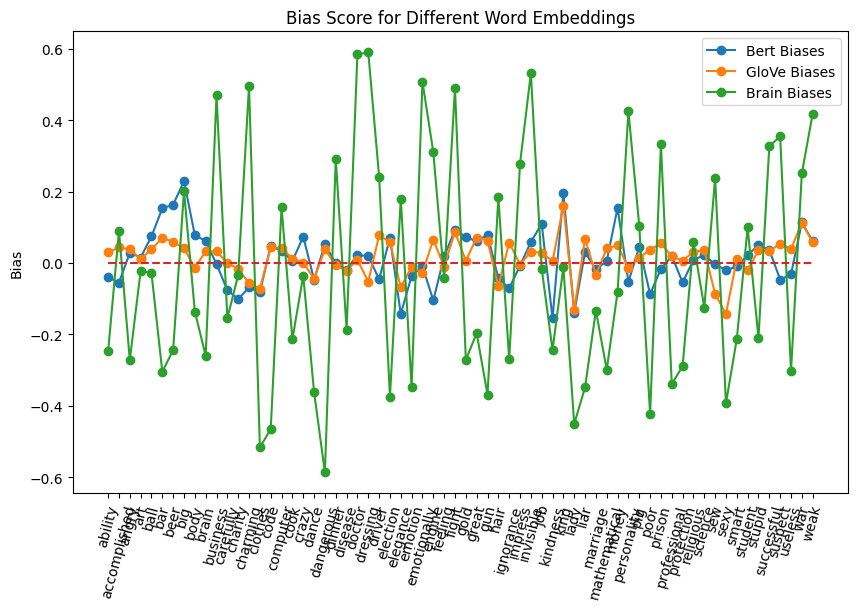

In [ ]:
bb = list(wd['Score'] for wd in bert_biases.values())
gb = list(wd['Score'] for wd in glove_biases.values())
fb = list(wd['Score'] for wd in fmri_biases.values())

plt.figure(figsize=(10,6))
plt.plot(ba_concepts, bb, marker='o', label='Bert Biases')
plt.plot(ba_concepts, gb, marker='o', label='GloVe Biases')
plt.plot(ba_concepts, fb, marker='o', label='Brain Biases')
plt.plot(ba_concepts, np.zeros(len(ba_concepts)), linestyle='--')
plt.legend()
plt.xticks(rotation=75)
plt.ylabel('Bias')
plt.title('Bias Score for Different Word Embeddings')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


The Words Clustered with Males are: ['ability', 'angry', 'big', 'carefully', 'charming', 'cook', 'crazy', 'dangerous', 'doctor', 'dressing', 'emotionally', 'feeling', 'fight', 'great', 'gun', 'ignorance', 'impress', 'invisible', 'job', 'kindness', 'king', 'lady', 'liar', 'pig', 'poor', 'sexy', 'smart', 'student', 'stupid', 'useless', 'weak']
The Words Clustered with Females are: ['accomplished', 'driver', 'gold', 'marriage', 'suspect']


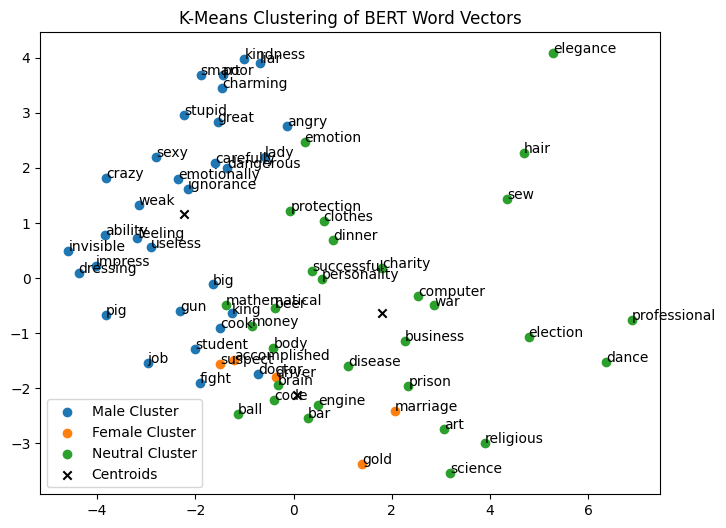

{'engineer': 'Neutral', 'lawyer': 'Neutral', 'soldier': 'Male', 'nurse': 'Male', 'dancer': 'Neutral', 'housekeeper': 'Male', 'loyal': 'Male', 'honest': 'Male', 'strong': 'Male', 'maternal': 'Male', 'attractive': 'Male', 'tidy': 'Male'}


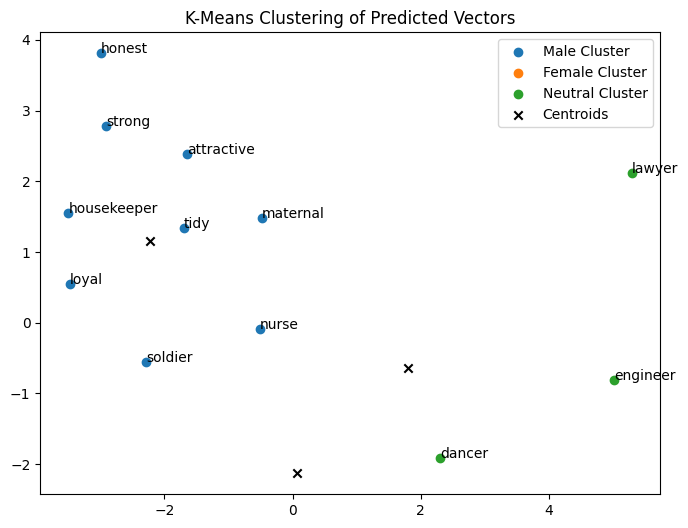

In [ ]:
run_kmeans_analysis(male_bert_pca, female_bert_pca, nv_bert, ba_bert_pca, ba_concepts, reduction=None, embedding='BERT', to_predict=test_bert_pca, words_to_predict=word_list, show_names=True)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


The Words Clustered with Males are: ['accomplished', 'art', 'big', 'business', 'charming', 'dinner', 'doctor', 'dressing', 'driver', 'elegance', 'emotionally', 'engine', 'fight', 'hair', 'impress', 'invisible', 'personality', 'pig', 'prison', 'religious', 'sew', 'successful', 'suspect', 'war', 'weak']
The Words Clustered with Females are: ['dance']


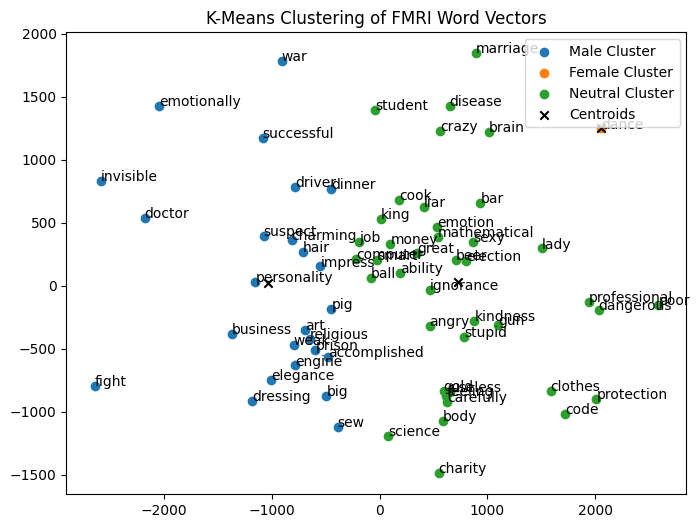

In [ ]:
run_kmeans_analysis(male_fmri_pca, female_fmri_pca, nv_fmri, ba_fmri_pca, ba_concepts, reduction=None, embedding='FMRI', show_names=True)

In [ ]:
bert_pca_added = np.append(ba_bert_pca, np.reshape(bert_pca[180], (1, bert_pca.shape[1])), axis=0)
bert_pca_added = np.append(bert_pca_added, np.reshape(bert_pca[181], (1, bert_pca.shape[1])), axis=0)

Cluster 1
['code']
Cluster 2
['fight']
Cluster 3
['big' 'successful']
Cluster 4
['crazy' 'dressing' 'feeling' 'sexy']
Cluster 5
['charming' 'lady']
Cluster 6
['great']
Cluster 7
['ball' 'impress' 'money' 'pig']
Cluster 8
['gold']
Cluster 9
['poor' 'smart' 'stupid']
Cluster 10
['hair']
Cluster 11
['carefully']
Cluster 12
['angry' 'emotion' 'kindness']
Cluster 13
['body']
Cluster 14
['charity' 'elegance' 'engine' 'personality']
Cluster 15
['dangerous' 'ignorance' 'suspect' 'useless' 'weak' 'Male' 'Female']
Cluster 16
['election' 'marriage' 'prison']
Cluster 17
['invisible']
Cluster 18
['bar' 'gun']
Cluster 19
['accomplished']
Cluster 20
['beer' 'clothes' 'cook' 'dinner']
Cluster 21
['science']
Cluster 22
['sew']
Cluster 23
['doctor' 'driver' 'king' 'professional' 'student']
Cluster 24
['religious']
Cluster 25
['ability' 'emotionally' 'protection']
Cluster 26
['computer' 'mathematical']
Cluster 27
['brain' 'disease' 'war']
Cluster 28
['art' 'business' 'dance']
Cluster 29
['liar']
Cluster 

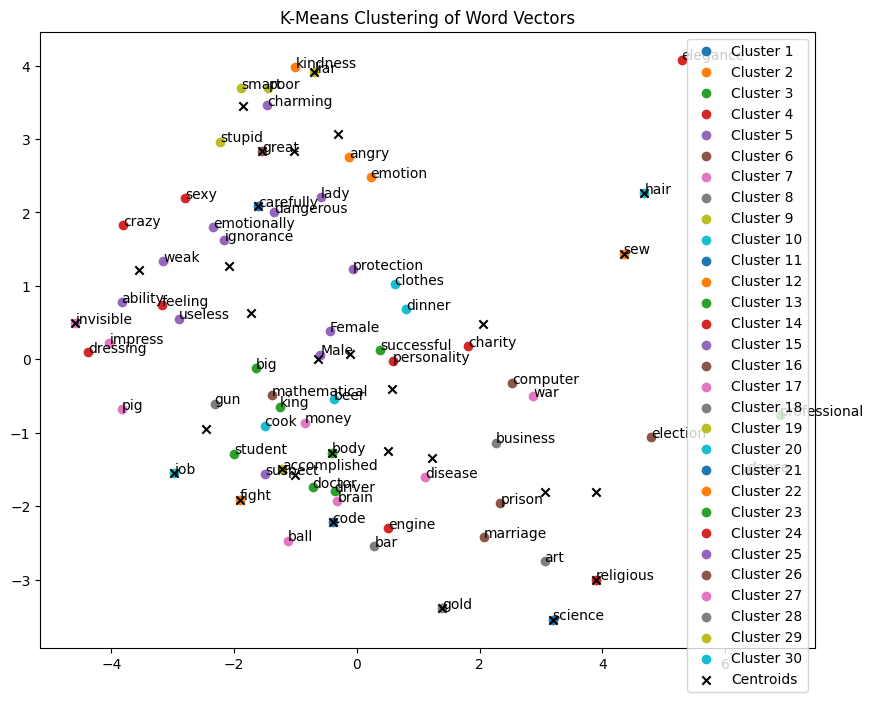

{'engineer': 'Neutral', 'lawyer': 'Neutral', 'soldier': 'Neutral', 'nurse': 'Neutral', 'dancer': 'Neutral', 'housekeeper': 'Male', 'loyal': 'Neutral', 'honest': 'Neutral', 'strong': 'Neutral', 'maternal': 'Male', 'attractive': 'Neutral', 'tidy': 'Male'}


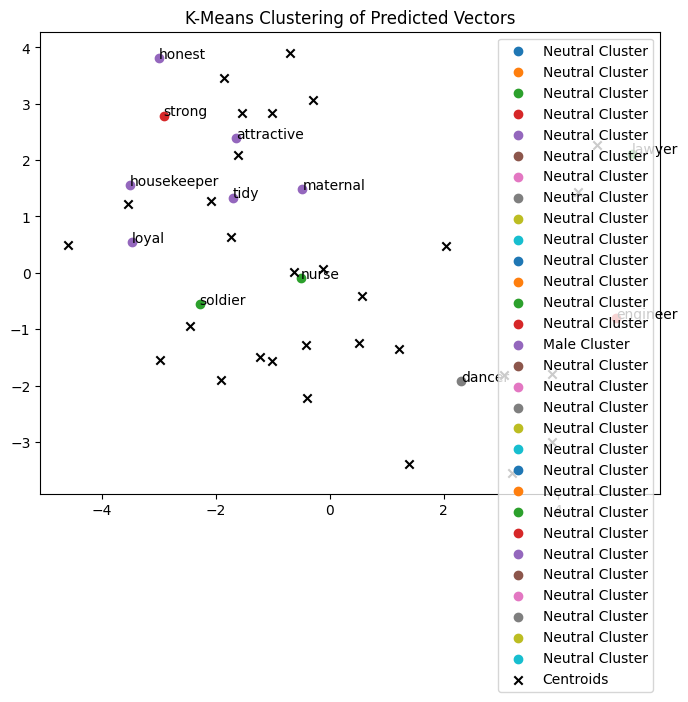

In [ ]:
run_random_kmeans(30, bert_pca_added, ba_concepts_added, test_bert_pca, word_list, True)

## Debiasing Word Embeddings

### Functions

In [ ]:
bert_male = ['war', 'money', 'king', 'job', 'gun', 'great', 'fight', 'election', 'big', 'beer']
bert_female = ['protection', 'lady', 'kindness', 'elegance']
glove_male = ['war', 'liar', 'great', 'fight', 'engine', 'driver', 'bar']
glove_female = ['sexy', 'sew', 'marriage', 'lady', 'hair', 'emotionally', 'elegance', 'dressing', 'dance', 'clothes', 'charming']
fmri_male = ['personality', 'invisible', 'fight', 'engine', 'emotionally', 'dressing', 'doctor', 'charming', 'business']
fmri_female = ['sexy', 'poor', 'lady', 'dangerous', 'dance', 'code', 'clothes']
pca_bert_male = ['war', 'money', 'king', 'job', 'gun', 'gold', 'fight', 'crazy', 'body', 'big', 'beer', 'bar', 'ball']
pca_bert_female = ['poor', 'lady', 'kindness', 'engine', 'elegance', 'clothes', 'charity', 'carefully']
fmri_pca_male = ['weak', 'personality', 'invisible', 'fight', 'emotionally', 'dressing', 'doctor', 'charming', 'business']
fmri_pca_female =['sexy', 'poor', 'lady', 'dangerous', 'code', 'clothes']

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

def bert_embedding (words_lst):

  inputs = tokenizer(list(words_lst), return_tensors="pt", padding=True)
  outputs = model(**inputs)

  last_hidden_states = outputs.last_hidden_state
  vectors_bert = last_hidden_states[:,1,:].detach().numpy()

  return vectors_bert

In [ ]:
from scipy.linalg import svd

def identify_gender_subspace(vectors, k= 1): #identifies a direction or subspace that captures the gender bias in the word embeddings
  means= []

  for i in range (0, vectors.shape[0], 2):
    means.append((vectors[i]+ vectors[i+1])/2)

  C = np.zeros((vectors.shape[1], vectors.shape[1]))

  for i in range (0, vectors.shape[0], 2):
    mean_index = int(i/2)
    C += np.outer(vectors[i]- means[mean_index], vectors[i]- means[mean_index])/2
    C += np.outer(vectors[i+1]- means[mean_index], vectors[i+1]- means[mean_index])/2

  _, _, V = svd(C)
  subspace = V[:k]

  return subspace

In [ ]:
def neutralize_debias(definitional_pairs,neutralize_set):
  new_embedding= []
  subspace = identify_gender_subspace(definitional_pairs)

  for word in neutralize_set: #gender neutral words will be 0 in the gender subspace
    projection = np.dot(subspace.T, np.dot(subspace, word))
    word = (word- projection)/ np.linalg.norm(word- projection)
    new_embedding.append(word)

  return new_embedding

In [ ]:
def equalize_debias (definitional_pairs, equality_set):
  new_embedding= []
  subspace = identify_gender_subspace(definitional_pairs)

  mean = np.mean(equality_set, axis= 0)
  mean_projection = np.dot(subspace.T, np.dot(subspace, mean))
  v = mean- mean_projection
  for word in equality_set: #neutral words will be equidistant to all words in each equality set

        word_calc1 = np.sqrt(1-((np.linalg.norm(v)/v.shape[0])**2))
        word_projection = np.dot(subspace.T, np.dot(subspace, word))
        word_calc2= (word_projection- mean_projection)/ (np.linalg.norm(word_projection- mean_projection))
        new_embedding.append(word_calc1*word_calc2 + v)

  return new_embedding

In [ ]:
import cvxpy as cp

def soft_debias(all_words, reg, N, B):
  new_embeddings = []
  n= all_words.shape[0]
  T = cp.Variable((n, n))

  print(T.shape)
  print(all_words.shape)

  objective = cp.Minimize((cp.norm(((T @ all_words).T @ (T @ all_words) - all_words.T @ all_words), 'fro')**2)+ reg*(cp.norm(((T @ N).T @ (T @ B)), 'fro')**2))
  problem = cp.Problem(objective)
  problem.solve()

  T_optimal = T.value
  print(T_optimal)

  for word in all_words:
    word= (word.T)*T_optimal
    new_embeddings.append(word)

  return new_embeddings

In [ ]:
def analogy_vector(w1: str, w2: str, w3: str, e: dict) -> np.ndarray: # note that the function takes the word embedding dictionary as input.
  return e[w2]- e[w1] + e[w3]

In [ ]:
def analogy(w1: str, w2: str, w3: str, e: dict, k=5):
  y= analogy_vector(w1, w2, w3, e)
  neighbors= {}

  for word in e:
     neighbors[word] = cosine_similarity(y, e[word])

  neighbors = dict(sorted(neighbors.items(), key=lambda item: item[1], reverse= True))
  top_k_keys = []
  for i, key in enumerate(neighbors.keys()):
    if key!= w3:
        top_k_keys.append(key)
    if i == k:
        break

  print (w1 + " is to " +w2 +" as " +w3 +" is to: ")
  return top_k_keys

In [ ]:
def replace_embedding_after_debias (vectors_dict, words_to_change, new_embeddings):

  for key, value in zip(words_to_change, new_embeddings):
        vectors_dict[key] = value

  return vectors_dict

In [ ]:
def set_embeddings (embeddings_dict, definitional_pairs, equalize_pairs, neutralize_words):
  definitional_embeddings = [embeddings_dict[key] for key in definitional_pairs if key in embeddings_dict]
  definitional_embeddings= np.array(definitional_embeddings)
  equalize_embeddings  = [embeddings_dict[key] for key in equalize_pairs if key in embeddings_dict]
  equalize_embeddings= np.array(equalize_embeddings)
  neutralize_embeddings = [embeddings_dict[key] for key in neutralize_words if key in embeddings_dict]
  neutralize_embeddings= np.array(neutralize_embeddings)

  return definitional_embeddings,equalize_embeddings, neutralize_embeddings

### Data

In [ ]:
definitional_pairs = ["woman", "man", "girl", "boy", "she", "he", "mother", "father", "daughter", "son", "gal", "guy", "female", "male", "her",
                      "his", "herself", "himself", "mary", "john"]
equalize_pairs= ["monastery", "convent", "spokesman", "spokeswoman", "dad", "mom", "men", "women", "councilman", "councilwoman", "grandpa",
                 "grandma", "grandsons", "granddaughters", "testosterone", "estrogen", "uncle", "aunt", "wives", "husbands", "father", "mother",
                 "grandpa", "grandma", "he", "she", "boy", "girl", "boys", "girls", "brother", "sister", "brothers", "sisters", "businessman",
                 "businesswoman", "chairman", "chairwoman", "colt", "filly", "congressman", "congresswoman", "dad", "mom", "dads", "moms", "dudes",
                 "gals", "father", "mother", "fatherhood", "motherhood", "fathers", "mothers", "fella", "granny", "fraternity", "sorority",
                 "gelding", "mare", "gentleman", "lady", "gentlemen", "ladies", "grandfather", "grandmother", "grandson", "granddaughter",
                 "he", "she", "himself", "herself", "his", "her", "king", "queen", "kings", "queens", "male", "female", "males", "females",
                 "man", "woman", "men", "women", "nephew", "niece", "prince", "princess", "schoolboy", "schoolgirl", "son", "daughter", "sons",
                 "daughters"]
neutralize_words = [
    "tree","table","paper","wall","floor","door","window","lamp","computer","book","car","chair","plant","clock","shirt","hat","plate",
    "spoon","fork","mirror","cup","picture","painting","brush","knife","blanket","pillow","box","bowl","dog","cat","puppy", "kitten", "pen",
    "canvas", "paintbrush","person", "individual", "human", "being", "creature", "mortal",
     "figure", "body", "folk", "society", "mankind",
    "people", "humanity", "personage",
    "individuality", "soul",
    "individualism", "specimen", "identity", "selfhood", "existence", "life",
    "personality", "essence", "consciousness", "somesuch", "personhood",
    "somebody", "lifeform", "personification",
    "subject", "homosapien", "someone", "humanoid",
    "character","war", "money", "job", "gun", "great", "fight", "election", "big", "beer","protection", "kindness", "elegance",
    "liar", "engine", "driver", "bar", "sexy", "sew", "marriage", "hair", "emotionally", "dressing", "dance", "clothes", "charming",
    "invisible", "doctor", "business","poor","dangerous","code","gold", "crazy", "ball","charity", "carefully","weak"
]


In [ ]:
all_words = definitional_pairs+equalize_pairs+neutralize_words
all_words = set(all_words)

### Bert

In [ ]:
bert_vectors_definitional = bert_embedding(definitional_pairs)
bert_vectors_equalize = bert_embedding(equality_sets)
bert_vectors_neutralize = bert_embedding(neutralize_words)
bert_vectors_words_to_debias = bert_embedding(words_to_debias)

In [ ]:
embeddings_equalize_debias= equalize_debias(bert_vectors_definitional,bert_vectors_equalize)
embeddings_neutralize_debias = neutralize_debias(bert_vectors_definitional,bert_vectors_neutralize)
all_words_neutralize= neutralize_debias(bert_vectors_definitional,bert_vectors_words_to_debias)
all_words_equalize= equalize_debias(bert_vectors_definitional,bert_vectors_words_to_debias)

Results - equalize debias

In [ ]:
print(f'Before running debias:')
print(analogy("man","woman","king",equality_sets,bert_vectors_equalize ))
print(analogy("father","mother","grandpa",equality_sets,bert_vectors_equalize ))
print(analogy("she","he","girl",equality_sets,bert_vectors_equalize ))

Before running debias:
man is to woman as king is to: 
['woman', 'queen', 'prince', 'princess', 'lady']
father is to mother as grandpa is to: 
['grandma', 'granny', 'grandmother', 'grandfather', 'mother']
she is to he as girl is to: 
['boy', 'woman', 'man', 'brother', 'he']


In [ ]:
print(f'After running debias:')
print(analogy("man","woman","king",equality_sets,embeddings_equalize_debias ))
print(analogy("father","mother","grandpa",equality_sets,embeddings_equalize_debias ))
print(analogy("she","he","girl",equality_sets,embeddings_equalize_debias ))

After running debias:
man is to woman as king is to: 
['monastery', 'convent', 'spokesman', 'spokeswoman', 'catholic_priest', 'councilman']
father is to mother as grandpa is to: 
['nun', 'dad', 'mom', 'men', 'women']
she is to he as girl is to: 
['nun', 'dad', 'mom', 'men', 'women', 'grandpa']


Results - neutralize debias

In [ ]:
print(f'Before running debias:')
print(analogy("paper","pen","canvas",neutralize_words,bert_vectors_neutralize ))
print(analogy("dog","cat","puppy",neutralize_words,bert_vectors_neutralize ))

Before running debias:
paper is to pen as canvas is to: 
['pen', 'lamp', 'window', 'bowl', 'spoon']
dog is to cat as puppy is to: 
['cat', 'spoon', 'kitten', 'bowl', 'window']


In [ ]:
print(f'After running debias:')
print(analogy("paper","pen","canvas",neutralize_words,embeddings_neutralize_debias ))
print(analogy("dog","cat","puppy",neutralize_words,embeddings_neutralize_debias ))

After running debias:
paper is to pen as canvas is to: 
['pen', 'window', 'lamp', 'spoon', 'painting']
dog is to cat as puppy is to: 
['cat', 'kitten', 'spoon', 'bowl', 'window']


Neutralize and Equalize on "words to debias"

In [ ]:
print(f'Before running debias:')
print(analogy("paper","pen","canvas",words_to_debias,bert_vectors_words_to_debias ))
print(analogy("dog","cat","puppy",words_to_debias,bert_vectors_words_to_debias ))

Before running debias:
paper is to pen as canvas is to: 
['pen', 'lamp', 'window', 'bowl', 'spoon']
dog is to cat as puppy is to: 
['cat', 'spoon', 'kitten', 'ability', 'bowl']


In [ ]:
print(f'After running neutralize debias:')
print(analogy("paper","pen","canvas",words_to_debias,all_words_neutralize ))
print(analogy("dog","cat","puppy",words_to_debias,all_words_neutralize ))

After running neutralize debias:
paper is to pen as canvas is to: 
['pen', 'window', 'lamp', 'pig', 'spoon']
dog is to cat as puppy is to: 
['cat', 'kitten', 'spoon', 'ability', 'bowl']


In [ ]:
print(f'After running equalize debias:')
print(analogy("paper","pen","canvas",words_to_debias,all_words_equalize ))
print(analogy("dog","cat","puppy",words_to_debias,all_words_equalize ))

After running equalize debias:
paper is to pen as canvas is to: 
['dance', 'election', 'hair', 'liar', 'professional', 'beer']
dog is to cat as puppy is to: 
['ability', 'art', 'elegance', 'mathematical', 'pig', 'sew']


### GloVe

In [ ]:
glove_vectors_definitional = get_glove_embeddings(definitional_pairs)
glove_vectors_equalize = get_glove_embeddings(equality_sets)
glove_vectors_neutralize = get_glove_embeddings(neutralize_words)
glove_vectors_words_to_debias = get_glove_embeddings(words_to_debias)

In [ ]:
embeddings_equalize_debias_glove= equalize_debias(glove_vectors_definitional,glove_vectors_equalize)
embeddings_neutralize_debias_glove = neutralize_debias(glove_vectors_definitional,glove_vectors_neutralize)
all_words_neutralize_glove= neutralize_debias(glove_vectors_definitional,glove_vectors_words_to_debias)
all_words_equalize_glove= equalize_debias(glove_vectors_definitional,glove_vectors_words_to_debias)

Results - equalize debias

In [ ]:
print(f'Before running debias:')
print(analogy("man","woman","king",equality_sets,glove_vectors_equalize ))
print(analogy("father","mother","grandpa",equality_sets,glove_vectors_equalize ))
print(analogy("she","he","girl",equality_sets,glove_vectors_equalize ))

Before running debias:
man is to woman as king is to: 
['queen', 'prince', 'princess', 'woman', 'daughter']
father is to mother as grandpa is to: 
['grandma', 'aunt', 'mom', 'grandmother', 'mother']
she is to he as girl is to: 
['boy', 'man', 'he', 'girls', 'boys']


In [ ]:
print(f'After running debias:')
print(analogy("man","woman","king",equality_sets,embeddings_equalize_debias_glove ))
print(analogy("father","mother","grandpa",equality_sets,embeddings_equalize_debias_glove ))
print(analogy("she","he","girl",equality_sets,embeddings_equalize_debias_glove ))

After running debias:
man is to woman as king is to: 
['convent', 'spokeswoman', 'mom', 'women', 'councilwoman', 'grandma']
father is to mother as grandpa is to: 
['convent', 'spokeswoman', 'mom', 'women', 'councilwoman', 'grandma']
she is to he as girl is to: 
['grandsons', 'brother', 'fatherhood', 'king', 'prince', 'monastery']


Results - neutralize debias

In [ ]:
print(f'Before running debias:')
print(analogy("paper","pen","canvas",neutralize_words,glove_vectors_neutralize ))
print(analogy("dog","cat","puppy",neutralize_words,glove_vectors_neutralize ))

Before running debias:
paper is to pen as canvas is to: 
['pen', 'painting', 'brush', 'paintbrush', 'shirt']
dog is to cat as puppy is to: 
['cat', 'kitten', 'dog', 'picture', 'box']


In [ ]:
print(f'After running debias:')
print(analogy("paper","pen","canvas",neutralize_words,embeddings_neutralize_debias_glove ))
print(analogy("dog","cat","puppy",neutralize_words,embeddings_neutralize_debias_glove ))

After running debias:
paper is to pen as canvas is to: 
['pen', 'painting', 'brush', 'paintbrush', 'shirt']
dog is to cat as puppy is to: 
['cat', 'kitten', 'dog', 'picture', 'box']


Neutralize and Equalize on "words to debias"

In [ ]:
print(f'Before running debias:')
print(analogy("paper","pen","canvas",words_to_debias,glove_vectors_words_to_debias ))
print(analogy("dog","cat","puppy",words_to_debias,glove_vectors_words_to_debias ))

Before running debias:
paper is to pen as canvas is to: 
['pen', 'painting', 'brush', 'paintbrush', 'art']
dog is to cat as puppy is to: 
['cat', 'kitten', 'dog', 'girl', 'picture']


In [ ]:
print(f'After running neutralize debias:')
print(analogy("paper","pen","canvas",words_to_debias,all_words_neutralize_glove ))
print(analogy("dog","cat","puppy",words_to_debias,all_words_neutralize_glove ))

After running neutralize debias:
paper is to pen as canvas is to: 
['pen', 'painting', 'brush', 'paintbrush', 'art']
dog is to cat as puppy is to: 
['cat', 'kitten', 'dog', 'girl', 'picture']


In [ ]:
print(f'After running equalize debias:')
print(analogy("paper","pen","canvas",words_to_debias,all_words_equalize_glove ))
print(analogy("dog","cat","puppy",words_to_debias,all_words_equalize_glove ))

After running equalize debias:
paper is to pen as canvas is to: 
['dance', 'elegance', 'pig', 'charming', 'emotion', 'student']
dog is to cat as puppy is to: 
['dance', 'elegance', 'pig', 'charming', 'emotion', 'student']


### Debias 200 words (glove)

Analogy test

In [ ]:
glove_vectors_debias = get_glove_embeddings(all_words)
glove_vectors_dict = {key: value for key, value in zip(all_words, glove_vectors_debias)}

In [ ]:
print(f'Before running debias:')
print(analogy("man","woman","king",glove_vectors_dict))
print(analogy("father","mother","grandpa",glove_vectors_dict))
print(analogy("she","he","girl",glove_vectors_dict ))

print(analogy("paper","pen","canvas",glove_vectors_dict))
print(analogy("dog","cat","puppy",glove_vectors_dict))
print(analogy("man","code","woman",glove_vectors_dict))
print(analogy("woman","doctor","man",glove_vectors_dict))

Before running debias:
man is to woman as king is to: 
['queen', 'prince', 'princess', 'woman', 'daughter']
father is to mother as grandpa is to: 
['grandma', 'aunt', 'mom', 'grandmother', 'mother']
she is to he as girl is to: 
['boy', 'man', 'guy', 'he', 'girls']
paper is to pen as canvas is to: 
['pen', 'painting', 'brush', 'paintbrush', 'shirt']
dog is to cat as puppy is to: 
['cat', 'kitten', 'dog', 'girl', 'picture']
man is to code as woman is to: 
['code', 'women', 'girl', 'subject', 'protection']
woman is to doctor as man is to: 
['doctor', 'he', 'his', 'brother', 'guy']


In [ ]:
definitional_embeddings,equalize_embeddings, neutralize_embeddings = set_embeddings(glove_vectors_dict)

In [ ]:
embeddings_neutralize_debias_glove = neutralize_debias(definitional_embeddings,neutralize_embeddings)
glove_vectors_dict = replace_embedding_after_debias(glove_vectors_dict, neutralize_words, embeddings_neutralize_debias_glove)
embeddings_equalize_debias_glove= equalize_debias(definitional_embeddings,equalize_embeddings)
glove_vectors_dict = replace_embedding_after_debias(glove_vectors_dict, equalize_pairs, embeddings_equalize_debias_glove)

In [ ]:
print(f'After running debias:')
print(analogy("man","woman","king",glove_vectors_dict))
print(analogy("father","mother","grandpa",glove_vectors_dict))
print(analogy("she","he","girl",glove_vectors_dict ))

print(analogy("paper","pen","canvas",glove_vectors_dict))
print(analogy("dog","cat","puppy",glove_vectors_dict))
print(analogy("man","code","woman",glove_vectors_dict))
print(analogy("woman","doctor","man",glove_vectors_dict))

After running debias:
man is to woman as king is to: 
['female', 'sisters', 'chairwoman', 'queen', 'filly', 'wives']
father is to mother as grandpa is to: 
['female', 'sisters', 'chairwoman', 'queen', 'filly', 'wives']
she is to he as girl is to: 
['grandsons', 'king', 'brother', 'prince', 'fatherhood', 'chairman']
paper is to pen as canvas is to: 
['pen', 'painting', 'brush', 'paintbrush', 'shirt']
dog is to cat as puppy is to: 
['cat', 'kitten', 'dog', 'picture', 'female']
man is to code as woman is to: 
['code', 'chairwoman', 'wives', 'ladies', 'daughter', 'lady']
woman is to doctor as man is to: 
['john', 'chairman', 'dudes', 'nephew', 'sons', 'gentlemen']


### Debias all words -glove

Analogy Test

In [ ]:
print(f'Before running debias:')
print(analogy("man","woman","king",all_embeddings))
print(analogy("father","mother","grandpa",all_embeddings))
print(analogy("she","he","girl",all_embeddings ))

print(analogy("paper","pen","canvas",all_embeddings))
print(analogy("dog","cat","puppy",all_embeddings))
print(analogy("man","code","woman",all_embeddings))
print(analogy("woman","doctor","man",all_embeddings))

Before running debias:


In [ ]:
definitional_embeddings,equalize_embeddings, neutralize_embeddings = set_embeddings(all_embeddings,  definitional_pairs, equalize_pairs, neutralize_words)

In [ ]:
embeddings_neutralize_debias_glove = neutralize_debias(definitional_embeddings,neutralize_embeddings)
glove_vectors_dict_debias = replace_embedding_after_debias(all_embeddings, neutralize_words, embeddings_neutralize_debias_glove)
embeddings_equalize_debias_glove= equalize_debias(definitional_embeddings,equalize_embeddings)
glove_vectors_dict_debias = replace_embedding_after_debias(glove_vectors_dict_debias, equalize_pairs, embeddings_equalize_debias_glove)

In [ ]:
print(f'After running debias:')
print(analogy("man","woman","king",glove_vectors_dict_debias))
print(analogy("father","mother","grandpa",glove_vectors_dict_debias))
print(analogy("she","he","girl",glove_vectors_dict_debias ))

print(analogy("paper","pen","canvas",glove_vectors_dict_debias))
print(analogy("dog","cat","puppy",glove_vectors_dict_debias))
print(analogy("man","code","woman",glove_vectors_dict_debias))
print(analogy("woman","doctor","man",glove_vectors_dict_debias))

Learn Decoder

In [ ]:
vectors_after_debias = [glove_vectors_dict_debias[key] for key in concepts if key in glove_vectors_dict_debias]
vectors_after_debias= np.array (vectors_after_debias)

In [ ]:
all_ranks_debias, avg_ranks_debias = train_decoder(data,vectors_after_debias, concepts)

In [ ]:
plot_fold_avg_acc(18,avg_ranks_debias)

In [ ]:
successful_debias, failed_debias = successful_failed_concepts(concepts, all_ranks_debias)

In [ ]:
plot_concepts(successful_debias, "successful concepts ", "after debias", "- glove embedding")

In [ ]:
plot_concepts(failed_debias, "failed concepts ", "after debias", "- glove embedding")

Bias Words

In [ ]:
# extracting relevant features for analysis. Note that indices89 & 90 (lady and king) are non gender-neutral
neutral_indices = [3, 4, 5, 6, 8, 9, 12, 13, 14, 17, 18, 21, 22, 23, 25, 27, 31, 33, 35, 37, 39, 43, 42, 44, 45, 46, 47, 48, 51, 52, 53, 55, 58, 60, 65, 66, 67, 70, 71, 72, 73, 78, 79, 81, 83, 84, 87, 91, 92, 93, 94, 95, 97, 98, 100, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 118, 119, 120, 121, 126, 127, 128, 129, 131, 132, 133, 135, 136, 139, 140, 141, 42, 143, 144, 145, 147, 148, 149, 150, 151, 152, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 174, 176, 177, 178, 179]
ba_concept_indices = [0, 1, 2, 7, 10, 11, 15, 16, 19, 20, 24, 26, 28, 29, 30, 32, 34, 36, 38, 40, 41, 49, 50, 54, 56, 57, 59, 61, 62, 63, 64, 68, 69, 74, 75, 76, 77, 80, 82, 85, 86, 88, 89, 90, 96, 99, 101, 104, 114, 117, 122, 123, 124, 125, 130, 134, 137, 138, 146, 153, 154, 155, 157, 171, 173, 175]
ba_concepts = []
ba_glove = []
for index in ba_concept_indices:
    ba_concepts.append(concepts[index])
    ba_glove.append(vectors_after_debias[index])

ba_glove = np.array(ba_glove)

In [ ]:
male_glove = create_gender_vector(male=True)
female_glove = create_gender_vector(male=False)

In [ ]:
lower_glove, upper_glove, nv_glove = neutral_dist(male_glove, female_glove, vectors_after_debias, neutral_indices, bins=10, threshold=0.1)

In [ ]:
glove_biases = create_bias_dict(male_glove, female_glove, ba_glove, lower_glove, upper_glove, ba_concepts)
glove_biases

In [ ]:
plot_top_biases(glove_biases, 'GloVe')

### Debias all words - Bert

In [ ]:
words_list_bert = list(all_words) + list(concepts)
words_list_bert= set(words_list_bert)
words_list_bert= list(words_list_bert)
all_embeddings_bert= bert_embedding(words_list_bert)

bert_vectors_dict = {key: value for key, value in zip(words_list_bert, all_embeddings_bert)}

In [ ]:
definitional_embeddings_bert,equalize_embeddings_bert, neutralize_embeddings_bert = set_embeddings(bert_vectors_dict, definitional_pairs, equalize_pairs, neutralize_words)

In [ ]:
embeddings_neutralize_debias_bert = neutralize_debias(definitional_embeddings_bert,neutralize_embeddings_bert)
bert_vectors_dict_debias = replace_embedding_after_debias(bert_vectors_dict, neutralize_words, embeddings_neutralize_debias_bert)
embeddings_equalize_debias_bert= equalize_debias(definitional_embeddings_bert,equalize_embeddings_bert)
bert_vectors_dict_debias = replace_embedding_after_debias(bert_vectors_dict_debias, equalize_pairs, embeddings_equalize_debias_bert)

Learn Decoder

In [ ]:
bert_vectors_after_debias = [bert_vectors_dict_debias[key] for key in concepts if key in bert_vectors_dict_debias]
bert_vectors_after_debias= np.array (bert_vectors_after_debias)

In [ ]:
all_ranks_debias_bert, avg_ranks_debias_bert = train_decoder(data,bert_vectors_after_debias, concepts)

Average Score of Fold 1.0 is: 87.8
Average Score of Fold 2.0 is: 86.6
Average Score of Fold 3.0 is: 74.7
Average Score of Fold 4.0 is: 95.0
Average Score of Fold 5.0 is: 90.1
Average Score of Fold 6.0 is: 58.5
Average Score of Fold 7.0 is: 77.0
Average Score of Fold 8.0 is: 76.1
Average Score of Fold 9.0 is: 46.6
Average Score of Fold 10.0 is: 93.4
Average Score of Fold 11.0 is: 92.1
Average Score of Fold 12.0 is: 81.0
Average Score of Fold 13.0 is: 83.0
Average Score of Fold 14.0 is: 78.1
Average Score of Fold 15.0 is: 70.8
Average Score of Fold 16.0 is: 98.9
Average Score of Fold 17.0 is: 56.9
Average Score of Fold 18.0 is: 64.0


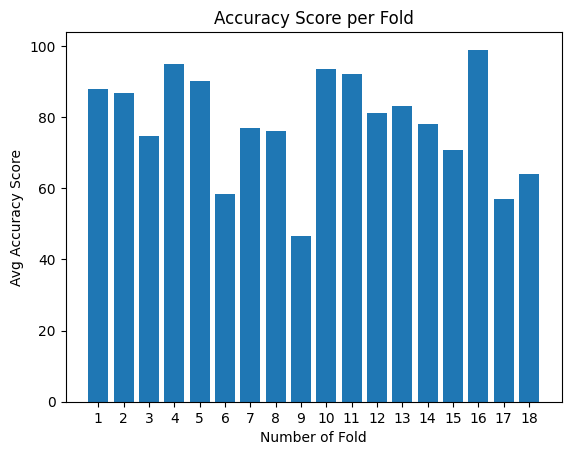

In [ ]:
plot_fold_avg_acc(18,avg_ranks_debias_bert)

In [ ]:
successful_debias_bert, failed_debias_bert = successful_failed_concepts(concepts, all_ranks_debias_bert)

Successful Concepts Are : {'fish': 2, 'lady': 2, 'crazy': 3, 'food': 3, 'dressing': 4, 'mechanism': 4, 'pig': 4, 'shape': 4, 'delivery': 5, 'investigation': 5, 'ability': 6, 'hurting': 6, 'broken': 9, 'beer': 11, 'impress': 12, 'argument': 17, 'extremely': 17, 'prison': 17, 'sexy': 17, 'invisible': 18, 'king': 18, 'garbage': 19, 'sell': 19, 'willingly': 19, 'dog': 20, 'mountain': 20, 'silly': 20, 'driver': 21, 'movement': 21, 'apartment': 24, 'bear': 25, 'light': 26, 'disease': 27, 'kindness': 27, 'tool': 27, 'texture': 28, 'art': 29, 'seafood': 29, 'dig': 30, 'magic': 30, 'toy': 30, 'deliberately': 31, 'plan': 31, 'unaware': 31, 'sin': 33, 'carefully': 34, 'experiment': 35, 'protection': 35, 'residence': 35, 'pleasure': 37, 'usable': 37, 'weak': 37, 'personality': 38, 'dissolve': 39, 'typical': 39, 'wear': 39, 'brain': 41, 'disturb': 41, 'ignorance': 42, 'useless': 43, 'device': 44, 'time': 44, 'doctor': 45, 'vacation': 45, 'feeling': 46, 'reaction': 48, 'solution': 48, 'sugar': 51, '

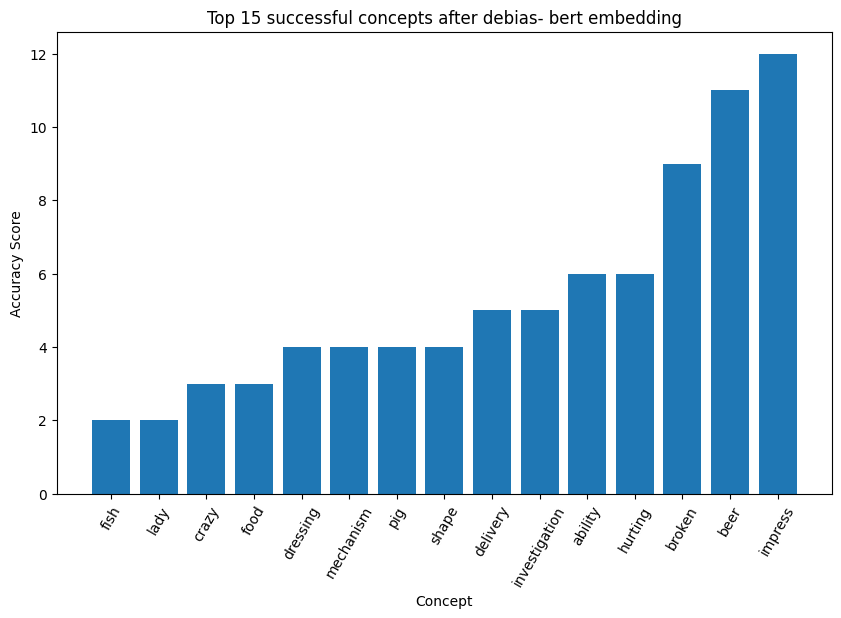

In [ ]:
plot_concepts(successful_debias_bert, "successful concepts ", "after debias", "- bert embedding")

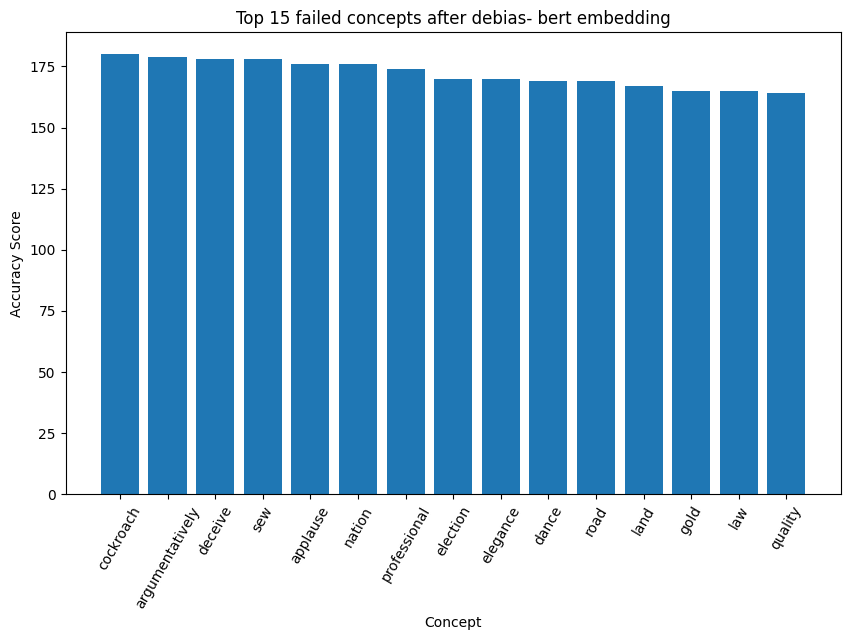

In [ ]:
plot_concepts(failed_debias_bert, "failed concepts ", "after debias", "- bert embedding")

Bias Words

In [ ]:
# extracting relevant features for analysis. Note that indices89 & 90 (lady and king) are non gender-neutral
neutral_indices = [3, 4, 5, 6, 8, 9, 12, 13, 14, 17, 18, 21, 22, 23, 25, 27, 31, 33, 35, 37, 39, 43, 42, 44, 45, 46, 47, 48, 51, 52, 53, 55, 58, 60, 65, 66, 67, 70, 71, 72, 73, 78, 79, 81, 83, 84, 87, 91, 92, 93, 94, 95, 97, 98, 100, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 118, 119, 120, 121, 126, 127, 128, 129, 131, 132, 133, 135, 136, 139, 140, 141, 42, 143, 144, 145, 147, 148, 149, 150, 151, 152, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 174, 176, 177, 178, 179]
ba_concept_indices = [0, 1, 2, 7, 10, 11, 15, 16, 19, 20, 24, 26, 28, 29, 30, 32, 34, 36, 38, 40, 41, 49, 50, 54, 56, 57, 59, 61, 62, 63, 64, 68, 69, 74, 75, 76, 77, 80, 82, 85, 86, 88, 89, 90, 96, 99, 101, 104, 114, 117, 122, 123, 124, 125, 130, 134, 137, 138, 146, 153, 154, 155, 157, 171, 173, 175]
ba_concepts = []
ba_bert = []
for index in ba_concept_indices:
    ba_concepts.append(concepts[index])
    ba_bert.append(bert_vectors_after_debias[index])

ba_bert = np.array(ba_bert)

In [ ]:
male_bert = create_gender_vector("bert", male=True)
female_bert= create_gender_vector("bert" ,male=False)

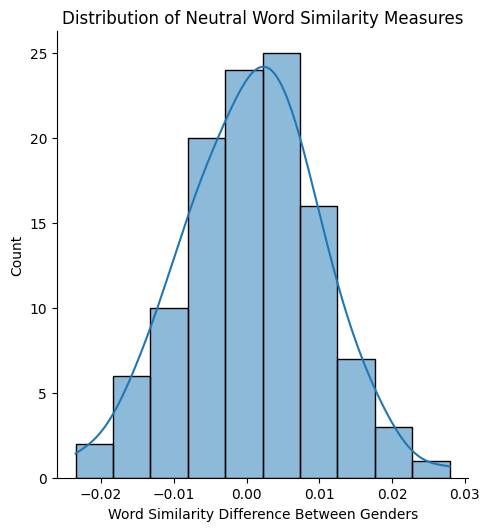

In [ ]:
lower_bert, upper_bert, nv_bert = neutral_dist(male_bert, female_bert, bert_vectors_after_debias, neutral_indices, bins=10, threshold=0.1)

In [ ]:
bert_biases = create_bias_dict(male_bert, female_bert, ba_bert, lower_bert, upper_bert, ba_concepts)
bert_biases

{'ability': {'Score': -0.00445191, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'accomplished': {'Score': -0.00290361,
  'Bias': 'Unbiased',
  'Biased To': 'None'},
 'angry': {'Score': 0.01250644, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'art': {'Score': 0.00575182, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'ball': {'Score': 0.01556552, 'Bias': 0.01556552, 'Biased To': 'Male'},
 'bar': {'Score': 0.02537614, 'Bias': 0.02537614, 'Biased To': 'Male'},
 'beer': {'Score': 0.02146909, 'Bias': 0.02146909, 'Biased To': 'Male'},
 'big': {'Score': 0.02995976, 'Bias': 0.02995976, 'Biased To': 'Male'},
 'body': {'Score': 0.00056277, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'brain': {'Score': 0.005711, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'business': {'Score': 0.00520704, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'carefully': {'Score': -0.00796548, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'charity': {'Score': -0.00614611, 'Bias': 'Unbiased', 'Biased To': 'None'},
 'charming': {'Score': 

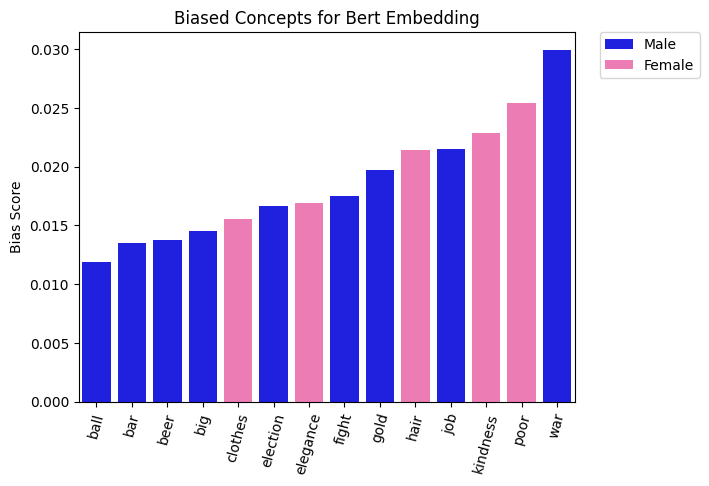

In [ ]:
plot_top_biases(bert_biases, 'Bert')

### Debias fmri

In [ ]:
#neutralize set
neutral_indices = [3, 4, 5, 6, 8, 9, 12, 13, 14, 17, 18, 21, 22, 23, 25, 27, 31, 33, 35, 37, 39, 43, 42, 44, 45, 46, 47, 48, 51, 52, 53, 55, 58, 60, 65, 66, 67, 70, 71, 72, 73, 78, 79, 81, 83, 84, 87, 91, 92, 93, 94, 95, 97, 98, 100, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 118, 119, 120, 121, 126, 127, 128, 129, 131, 132, 133, 135, 136, 139, 140, 141, 42, 143, 144, 145, 147, 148, 149, 150, 151, 152, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 174, 176, 177, 178, 179]

neutralize_fmri = []
neutralize_words_fmri= []
for index in neutral_indices:
    neutralize_fmri.append(data_c[index])
    neutralize_words_fmri.append(concepts[index])

neutralize_fmri = np.array(neutralize_fmri)

#equalize set
equalize_fmri = []
equalize_pairs_fmri= ["lady", "king", "boy", "girl"]
equalize_fmri.append(data_c[89]) #lady
equalize_fmri.append(data_c[90]) #king
equalize_fmri.append(fmri_exp2[209]) #boy
equalize_fmri.append(fmri_exp2[156]) #girl


#definitional set
definitional_fmri= []
definitional_fmri.append(fmri_exp2[208]) #male
definitional_fmri.append(fmri_exp2[380]) #female
definitional_fmri.append(fmri_exp2[209]) #boy
definitional_fmri.append(fmri_exp2[156]) #girl


neutralize_fmri = np.array(neutralize_fmri)
equalize_fmri = np.array(equalize_fmri)
definitional_fmri = np.array(definitional_fmri)

In [ ]:
extended_words = ["boy", "girl", "male", "female"]
words_list_fmri = concepts
words_list_fmri= np.append(concepts,extended_words )

extended_embeddings = [fmri_exp2[209], fmri_exp2[156], fmri_exp2[208], fmri_exp2[380]]
all_embeddings_fmri =np.append(data_c,extended_embeddings )

In [ ]:
fmri_vectors_dict = {key: value for key, value in zip(words_list_fmri, all_embeddings_fmri)}

In [ ]:
embeddings_neutralize_debias_fmri = neutralize_debias(definitional_fmri,neutralize_fmri)
fmri_vectors_dict_debias = replace_embedding_after_debias(fmri_vectors_dict, neutralize_words_fmri, embeddings_neutralize_debias_fmri)
embeddings_equalize_debias_fmri= equalize_debias(definitional_fmri,equalize_fmri)
fmri_vectors_dict_debias = replace_embedding_after_debias(fmri_vectors_dict_debias, equalize_pairs_fmri , embeddings_neutralize_debias_fmri)

### Summary and Results

Debiasing embeddings involves reducing or eliminating gender bias in word representations to reduce stereotypes, promote fairness, and address gender inequalities in natural language processing applications.

We attempted to recreate the algorithms described in the article "Man is to Computer Programmer as Woman is to Homemaker":

The first step, called "Identify gender subspace," is about finding a direction or pattern in the word embeddings that represents gender bias. It helps us understand how gender-related words are positioned in the embedding space.

The second step is "Neutralize and Equalize":
Neutralize ensures that words considered gender-neutral have zero influence in the gender subspace. It removes any bias associated with those words.
Equalize, on the other hand, tries to make sets of words that are outside the gender subspace to be equally distant from each other. This means that any gender-neutral word will have the same similarity or distance to all words in those sets. However, equalizing can remove certain distinctions that are useful in some applications.

We successfully recreated the algorithms described in the article. We created a neutralized set and an equalized set, similar to the sets used in the article, by selecting words from a large GloVe corpus. After applying the debiasing techniques to these sets and modifying the embeddings of the respective words, we ran "train decoder" on the same set of concepts and fMRI data as in previous experiments.
The average scores obtained from each fold were very close to the original results from previous experiments (HW3). The top three successful concepts remained identical, while some of the remaining top 15 concepts had similar words but with slightly different rankings. This indicates that the contextual relationships between words were preserved after debiasing.
When evaluating for bias using the same bias test as before, the results were remarkable. Only three words exhibited bias: "king" displayed bias towards males, "lady" showed bias towards females, and "hair" exhibited a very low bias towards females.

Overall, the results demonstrated the effectiveness of the debiasing algorithms in reducing biases in word embeddings while preserving contextual relationships between words. The results indicated significant improvements in mitigating gender bias and promoting fairness in language processing tasks.



*gpt - GloVe vs. Bert*

The performance of different algorithms on debiasing gender in word embeddings can vary based on their underlying architectures and training methodologies. In this case, running a debiasing algorithm on GloVe embeddings resulted in amazing results, while the same algorithm performed poorly on BERT embeddings. Let's explore some possible reasons for this difference:

Architecture Differences: GloVe and BERT have different underlying architectures. GloVe (Global Vectors for Word Representation) is a count-based model that learns word vectors based on co-occurrence statistics in a large corpus of text. On the other hand, BERT (Bidirectional Encoder Representations from Transformers) is a transformer-based model that learns contextualized word representations by training on a large amount of unlabeled text. These architectural differences can impact how gender biases are encoded and affect the performance of debiasing algorithms.

Contextual Embeddings: BERT provides contextualized word embeddings, meaning the embedding of a word can vary depending on its context within a sentence. This contextual nature of BERT embeddings can make it more challenging to detect and remove gender bias accurately. The debiasing algorithm might struggle to identify and neutralize gender associations due to the complex interactions between words and their contexts.

Bias Amplification: It's possible that the debiasing algorithm applied to BERT embeddings inadvertently amplified biases instead of mitigating them. If the algorithm mistakenly assigned higher importance to certain gender-related features during the debiasing process, it could have unintentionally exacerbated the bias present in the embeddings.

Dataset and Training Methodology: The performance of debiasing algorithms can be influenced by the dataset used for training and evaluation. It's possible that the algorithm was trained and evaluated on a dataset that better aligned with the characteristics of GloVe embeddings, leading to superior results for that specific type of embedding. The choice of debiasing algorithm and the specific techniques employed could also contribute to the disparity in performance.

Evaluation Metrics: The evaluation metrics used to assess the performance of debiasing algorithms might not have been appropriate or comprehensive enough to capture the nuances of gender bias in BERT embeddings. Different evaluation methodologies can yield contrasting results, making it essential to choose metrics that adequately capture the desired aspects of debiasing.

In summary, the differences in performance between debiasing gender algorithms applied to GloVe and BERT embeddings can be attributed to various factors, such as the architectural dissimilarities, contextual nature of BERT embeddings, bias amplification, dataset characteristics, training methodologies, and evaluation metrics. Understanding these factors is crucial for improving the effectiveness of debiasing algorithms and achieving more accurate and robust results in addressing gender bias in word embeddings.

# Export to PDF

Run the following cell to download the notebook as a nicely formatted pdf file.

In [ ]:
# Add to a new cell at the end of the notebook and run the follow code,
# which will save the notebook as pdf in your google drive (allow the permissions) and download it automatically.

!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py

from colab_pdf import colab_pdf

# If you saved the notebook in the default location in your Google Drive,
# and didn't change the name of the file, the code should work as is.
# If not, adapt accordingly.

colab_pdf(file_name='Copy of Pset_3.ipynb', notebookpath="/content/drive/MyDrive/Colab Notebooks/")

In [ ]:
%%shell
jupyter nbconvert --to html /content/Copy_of_Pset_3.ipynb